# Modules

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# Modules
import scipy as sp
from scipy import sparse, signal, stats
from astropy import convolution as conv
import numpy as np
import numpy.ma as ma
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from matplotlib import colors as clrs
import pandas as pd 
import time
import datetime
import calendar
import seaborn as sns
from copy import deepcopy

import multiprocessing as mp
from multiprocessing.dummy import Pool as ThreadPool

%matplotlib inline 

import sys
sys.path.insert(1, r'functions')  # add to pythonpath
from detect_peaks import detect_peaks


# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Font Size

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size'   : 21}

plt.rc('font', **font)



# Reading data

In [3]:
path ='D:/Mis Documentos/AAResearch/Codes/ADFSSN/runcsvs/' # use your path

PLH = [100]
PHH = [60, 75, 90]
QDH = [0]
ADH = [0.6, 0.75, 0.9]


PLL = [90]
PHL = [100]
QDL = [0.1, 0.25, 0.4]
ADL = [1.0]

# Reading reference
df = pd.read_csv(path + 'A_O_NB1_Observer_ADF.csv', header=0).drop_duplicates(subset='Observer', keep='last')
comObs = df['Observer'].values.copy() 
badObs = df['Observer'].values.copy()
badObs = badObs[np.logical_not(np.isfinite(df['mreSth']))]

# First pass to identify common observers
for ipl, pl in enumerate(PLL):
    for iph, ph in enumerate(PHL):
        for iqd, qd in enumerate(QDL):
            for iad, ad in enumerate(ADL):
                
                df = pd.read_csv(path + 'A_D_NB1_PL' + str(pl) + '_PH' + str(ph) + '_QD' + str(qd) + '_AD' + str(ad) + '_Observer_ADF.csv', header=0).drop_duplicates(subset='Observer', keep='last')
                comObs = np.intersect1d(comObs, df['Observer'].values, assume_unique=False, return_indices=False)
                
                tbadObs = df['Observer'].values.copy()
                tbadObs = tbadObs[np.logical_not(np.isfinite(df['mreSth']))]                
                badObs = np.concatenate((badObs, tbadObs))
                
                
for ipl, pl in enumerate(PLH):
    for iph, ph in enumerate(PHH):
        for iqd, qd in enumerate(QDH):
            for iad, ad in enumerate(ADH):
                
                df = pd.read_csv(path + 'A_D_NB1_PL' + str(pl) + '_PH' + str(ph) + '_QD' + str(qd) + '_AD' + str(ad) + '_Observer_ADF.csv', header=0).drop_duplicates(subset='Observer', keep='last')
                comObs = np.intersect1d(comObs, df['Observer'].values, assume_unique=False, return_indices=False)

                tbadObs = df['Observer'].values.copy()
                tbadObs = tbadObs[np.logical_not(np.isfinite(df['mreSth']))]                
                badObs = np.concatenate((badObs, tbadObs))                
                
badObs = np.unique(badObs)
comObs = np.setdiff1d(comObs,badObs)
                
                
## Creating multi-index dataframe from reference

# Reading reference and keeping only common observers
df = pd.read_csv(path + 'A_O_NB1_Observer_ADF.csv', header=0).drop_duplicates(subset='Observer', keep='last').set_index('Observer')
df = df.loc[comObs,:]

# Create Multi-index
MxInx = pd.MultiIndex.from_product([[0],[0],[0],[0],comObs], names=['PL', 'PH', 'QD', 'AD','Observer'])
MxDf = pd.DataFrame(df.values, index=MxInx, columns = df.columns)

# Append Runs
for ipl, pl in enumerate(PLL):
    for iph, ph in enumerate(PHL):
        for iqd, qd in enumerate(QDL):
            for iad, ad in enumerate(ADL):
                
                df = pd.read_csv(path + 'A_D_NB1_PL' + str(pl) + '_PH' + str(ph) + '_QD' + str(qd) + '_AD' + str(ad) + '_Observer_ADF.csv', header=0).drop_duplicates(subset='Observer', keep='last').set_index('Observer')
                df = df.loc[comObs,:]
                
                MxInx = pd.MultiIndex.from_product([[pl],[ph],[qd],[ad],comObs], names=['PL', 'PH', 'QD', 'AD','Observer'])
                tmpDf = pd.DataFrame(df.values, index=MxInx, columns = df.columns)
                                
                MxDf = MxDf.append(tmpDf)
                
for ipl, pl in enumerate(PLH):
    for iph, ph in enumerate(PHH):
        for iqd, qd in enumerate(QDH):
            for iad, ad in enumerate(ADH):
                
                df = pd.read_csv(path + 'A_D_NB1_PL' + str(pl) + '_PH' + str(ph) + '_QD' + str(qd) + '_AD' + str(ad) + '_Observer_ADF.csv', header=0).drop_duplicates(subset='Observer', keep='last').set_index('Observer')
                df = df.loc[comObs,:]
                
                MxInx = pd.MultiIndex.from_product([[pl],[ph],[qd],[ad],comObs], names=['PL', 'PH', 'QD', 'AD','Observer'])
                tmpDf = pd.DataFrame(df.values, index=MxInx, columns = df.columns)
                                
                MxDf = MxDf.append(tmpDf)                
                
                

In [4]:
MxDf

Station AvThreshold SDThreshold  \
PL  PH QD  AD  Observer                                                        
0   0  0.0 0.0 318                           Spoerer           9         NaN   
               323                           Ferrari          32         NaN   
               324                            Leppig          55         NaN   
               325                            Dawson          41         NaN   
               327                         Bernaerts          40         NaN   
               328                          Tacchini          36         NaN   
               329                            Secchi          48         NaN   
               330                        Billwiller          59         NaN   
               333                         Moncalier          63         NaN   
               334                              Main          76         NaN   
               335             Billwiller and wolfer          89         NaN   
               336                           Aguilar          48         NaN   
               337             Monthly weather revie          57         NaN   
               339                             Ricco          77         NaN   
               341                           Winkler          33         NaN   
               342                           Janesch          68         NaN   
               343                            Merino          15         NaN   
               344                           Kokides          29         NaN   
               345                           Konkoly          58         NaN   
               346                             Vogel          59         NaN   
               348                           Wilsing           0         NaN   
               349                           Schmoll          79         NaN   
               350            Haverford college obs.          33         NaN   
               351                           Yendell          87         NaN   
               352                            Quimby          45         NaN   
               353       Carleton college observator          25         NaN   
               354                             Frost          47         NaN   
               355                  Smith observator          39         NaN   
               356                            Hadden          26         NaN   
               358              Mount holyoke colleg          16         NaN   
...                                              ...         ...         ...   
100 90 0.0 0.9 590                          Janssens          60         NaN   
               591                  Johnston gwynedd           8         NaN   
               592              Havana solar station          51         NaN   
               595                    Jeffrey carels          19         NaN   
               596                         Kawaguchi           7         NaN   
               598                           Karjali          79         NaN   
               599                            Kladno           6         NaN   
               600                            Koyama           6         NaN   
               601              Observatory rokycany          30         NaN   
               602                        Kislovodsk          14         NaN   
               604                              Kiev          19         NaN   
               605                            Kayeme          45         NaN   
               607                          Larguier          27         NaN   
               612                             Looks          60         NaN   
               613                       Lieve meeus          89         NaN   
               615                         Learmouth          68         NaN   
               616               Larissa observatory          18         NaN   
               617                           

PL: 100 PH: 60QD: 0AD: 0.6 All Observers
-0.116
Act/Obs All Observers
-0.159
PL: 100 PH: 60QD: 0AD: 0.6 Th>30
0.004
Ac/Obs Th>30
-0.012


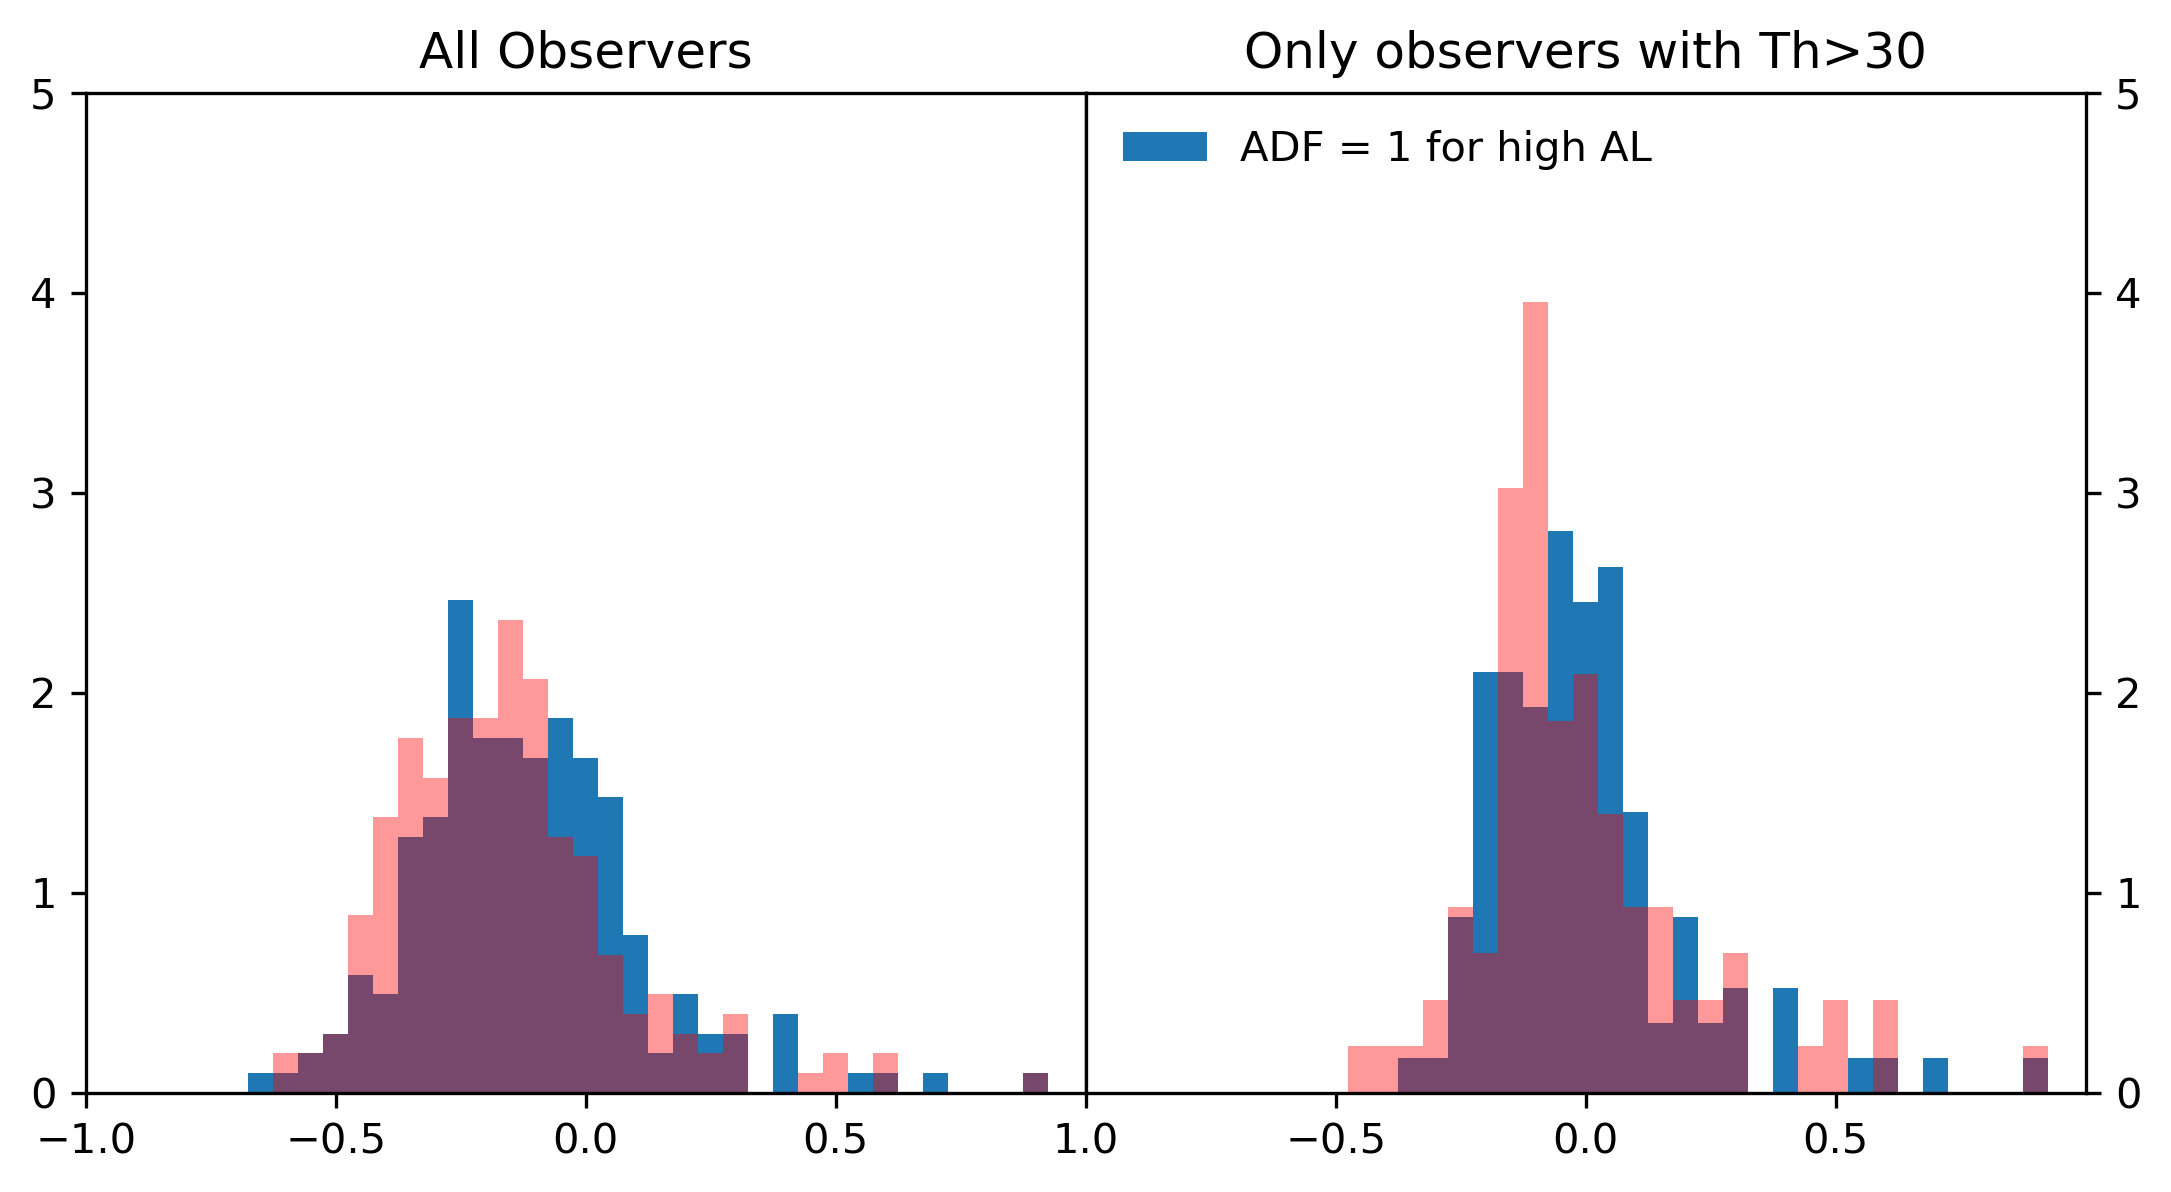

In [18]:
bins = np.arange(-1.3,1.3,.05)+0.025
top = 5
left = -1
right = 1

# Size definitions
dpi = 300
pxx = 1000   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 3      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units
                                
## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)                    
                
    
pl = 100
ph = 60
qd = 0
ad = 0.6

n = (nph*(iad)+iph)
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc], label= 'b1')

ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values), density = True, bins = bins)

print('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad) + ' All Observers')
print(np.round(np.mean((MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values)),decimals=3))


pl = 0
ph = 0
qd = 0
ad = 0    
    
ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values), density = True, bins = bins, color = 'r', alpha = 0.4)

print('Act/Obs All Observers')
print(np.round(np.mean((MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values)),decimals=3))

ax1.set_title('All Observers')                
ax1.set_ylim(top = top, bottom = 0)
ax1.set_xlim(right = right, left = left)

# ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values), density = True, bins = bins, color = 'r', alpha = 0.4)
    

pl = 100
ph = 60
qd = 0
ad = 0.6
    
ValMask = np.isfinite(np.double(MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values))
ValMask = np.logical_and(ValMask, MxDf.loc[([pl],[ph],[qd],[ad]),'AvThreshold']<30)  

n = (nph*(iad)+iph)
ax1 = fig.add_axes([ppadh + (pxx/fszh+ppadh2), ppadv, pxx/fszh*frc, pxy/fszv*frc], label= 'b2')

ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values[ValMask]), density = True, bins = bins)
ax1.set_title('Only observers with Th>30')                
ax1.set_ylim(top = top, bottom = 0)
ax1.set_xlim(right = right, left = left)
ax1.set_xticks(np.arange(-0.5,1,0.5))  
ax1.legend(['ADF = 1 for high AL', 'ADF = Act/Obs'], loc = 'upper left', ncol = 1, frameon = True, edgecolor = 'none')

print('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad) + ' Th>30')
print(np.round(np.mean((MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values[ValMask])),decimals=3))




pl = 0
ph = 0
qd = 0
ad = 0   

ValMask = np.isfinite(np.double(MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values))
ValMask = np.logical_and(ValMask, MxDf.loc[([pl],[ph],[qd],[ad]),'AvThreshold']<30)  


ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values[ValMask]), density = True, bins = bins, color = 'r', alpha = 0.4)
ax1.yaxis.set_label_position("right")    
ax1.yaxis.tick_right()    
ax1.set_xticks(np.arange(-0.5,1,0.5))  

print('Ac/Obs Th>30')
print(np.round(np.mean((MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values[ValMask])),decimals=3))
    
    

PL: 100 PH: 60QD: 0AD: 0.6 All Observers
0.894
Act/Obs All Observers
0.84
PL: 100 PH: 60QD: 0AD: 0.6 Th>30
1.014
Ac/Obs Th>30
0.992


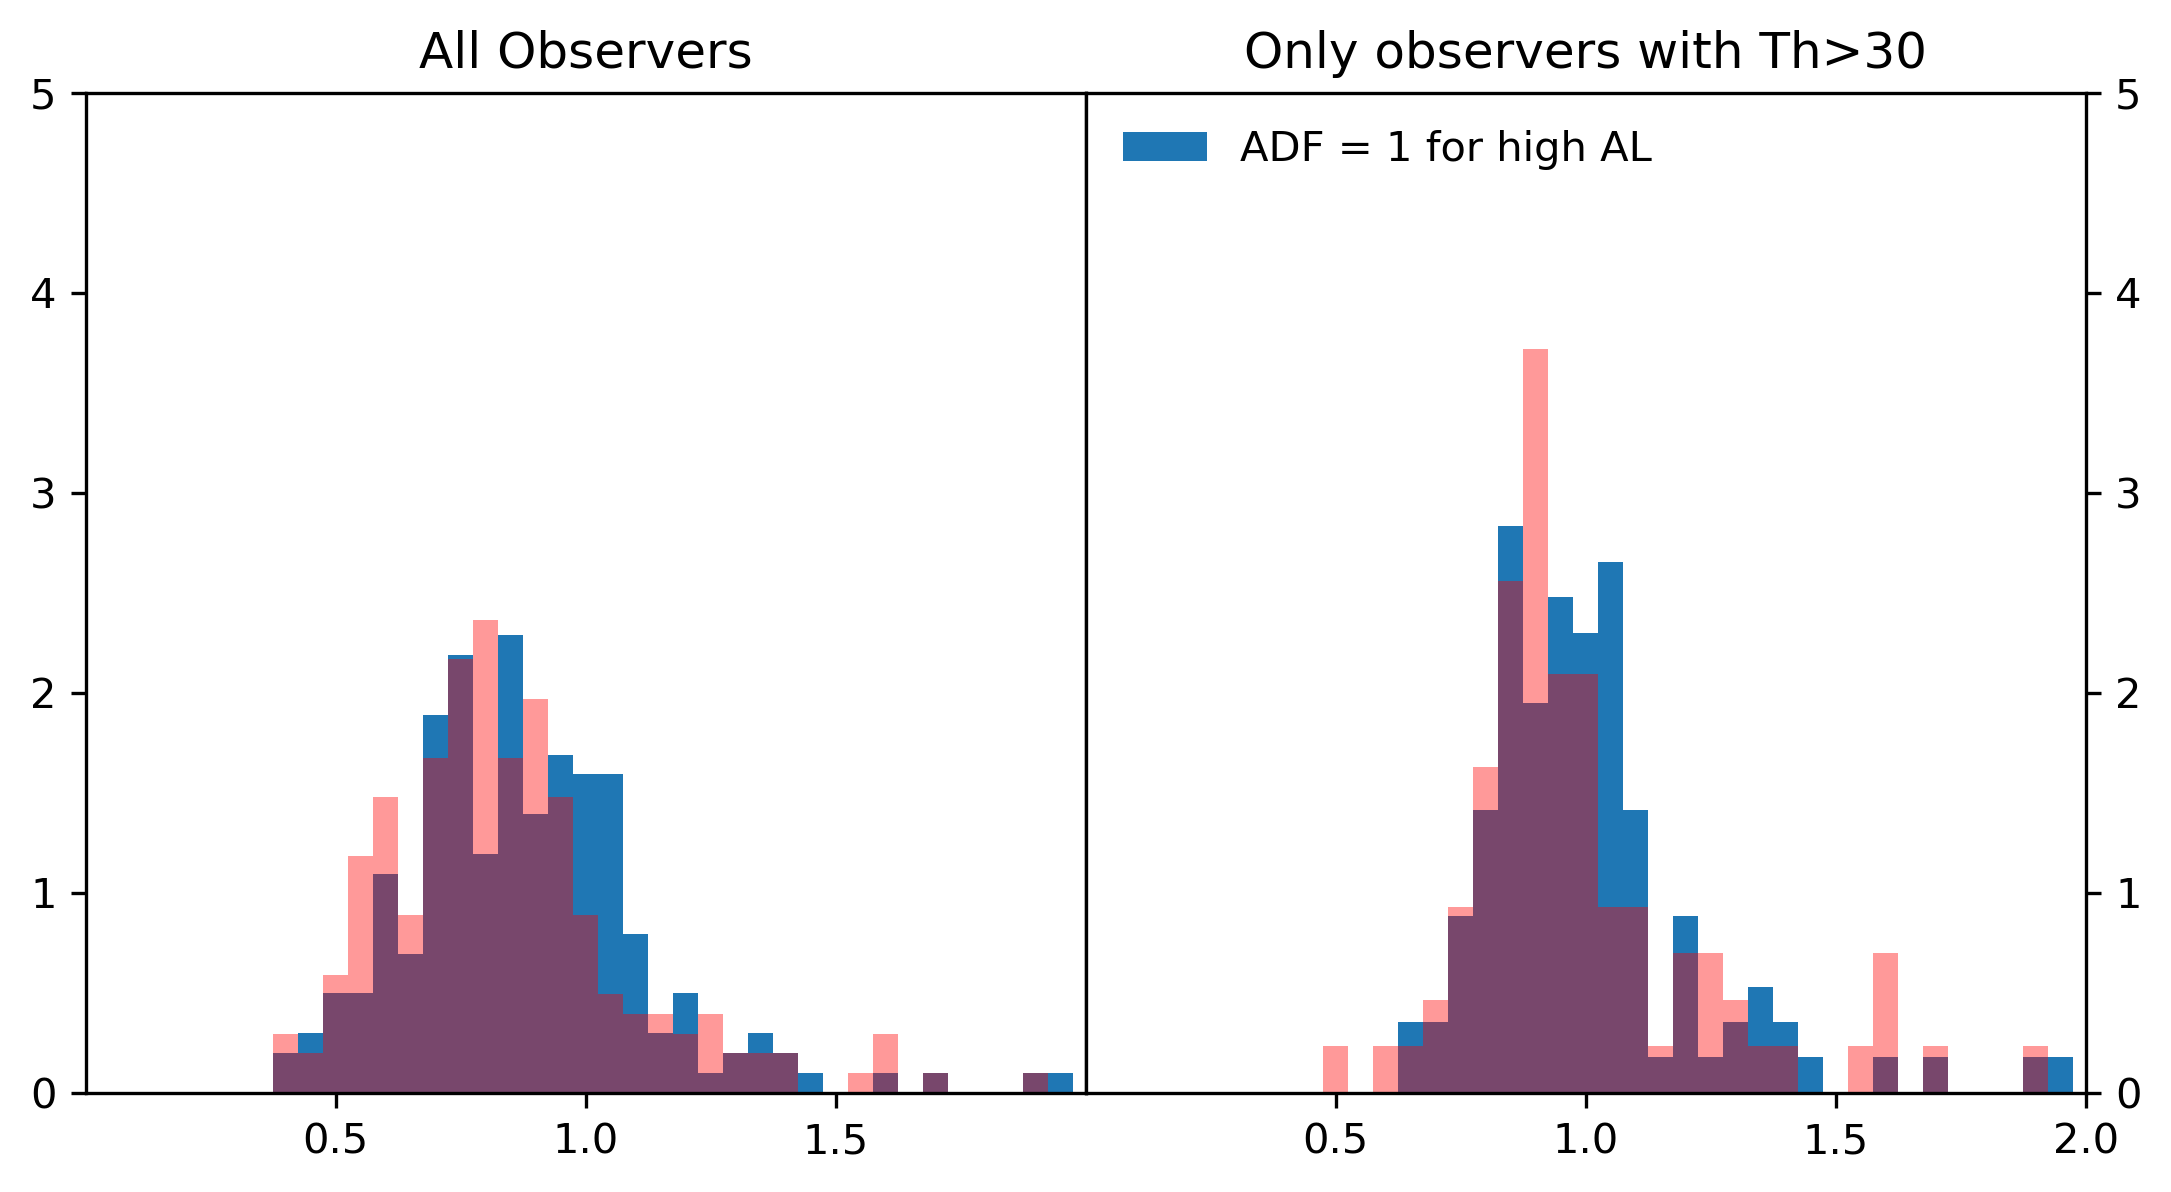

In [26]:
bins = np.arange(0,2,.05)+0.025
top = 5
left = 0
right = 2

# Size definitions
dpi = 300
pxx = 1000   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 3      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units
                                
## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)                    
                
    
pl = 100
ph = 60
qd = 0
ad = 0.6

n = (nph*(iad)+iph)
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc], label= 'b1')

ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'KSth'].values), density = True, bins = bins)

print('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad) + ' All Observers')
print(np.round(np.mean((MxDf.loc[([pl],[ph],[qd],[ad]),'KSth'].values)),decimals=3))


pl = 0
ph = 0
qd = 0
ad = 0    
    
ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'KSth'].values), density = True, bins = bins, color = 'r', alpha = 0.4)

print('Act/Obs All Observers')
print(np.round(np.mean((MxDf.loc[([pl],[ph],[qd],[ad]),'KSth'].values)),decimals=3))

ax1.set_title('All Observers')                
ax1.set_ylim(top = top, bottom = 0)
ax1.set_xlim(right = right, left = left)
ax1.set_xticks(np.arange(0.5,2,0.5))

# ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values), density = True, bins = bins, color = 'r', alpha = 0.4)
    

pl = 100
ph = 60
qd = 0
ad = 0.6
    
ValMask = np.isfinite(np.double(MxDf.loc[([pl],[ph],[qd],[ad]),'KSth'].values))
ValMask = np.logical_and(ValMask, MxDf.loc[([pl],[ph],[qd],[ad]),'AvThreshold']<30)  

n = (nph*(iad)+iph)
ax1 = fig.add_axes([ppadh + (pxx/fszh+ppadh2), ppadv, pxx/fszh*frc, pxy/fszv*frc], label= 'b2')

ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'KSth'].values[ValMask]), density = True, bins = bins)
ax1.set_title('Only observers with Th>30')                
ax1.set_ylim(top = top, bottom = 0)
ax1.set_xlim(right = right, left = left)
# ax1.set_xticks(np.arange(-0.5,1,0.5))  
ax1.legend(['ADF = 1 for high AL', 'ADF = Act/Obs'], loc = 'upper left', ncol = 1, frameon = True, edgecolor = 'none')

print('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad) + ' Th>30')
print(np.round(np.mean((MxDf.loc[([pl],[ph],[qd],[ad]),'KSth'].values[ValMask])),decimals=3))




pl = 0
ph = 0
qd = 0
ad = 0   

ValMask = np.isfinite(np.double(MxDf.loc[([pl],[ph],[qd],[ad]),'KSth'].values))
ValMask = np.logical_and(ValMask, MxDf.loc[([pl],[ph],[qd],[ad]),'AvThreshold']<30)  


ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'KSth'].values[ValMask]), density = True, bins = bins, color = 'r', alpha = 0.4)
ax1.yaxis.set_label_position("right")    
ax1.yaxis.tick_right()    
ax1.set_xticks(np.arange(0.5,2.5,0.5))  

print('Ac/Obs Th>30')
print(np.round(np.mean((MxDf.loc[([pl],[ph],[qd],[ad]),'KSth'].values[ValMask])),decimals=3))
    
    

PL: 100 PH: 60QD: 0AD: 0.6 Th>30
0.143
0.146
PL: 100 PH: 60QD: 0AD: 0.75 Th>30
0.122
0.098
PL: 100 PH: 60QD: 0AD: 0.9 Th>30
0.141
0.109
PL: 100 PH: 75QD: 0AD: 0.6 Th>30
0.121
0.133
PL: 100 PH: 75QD: 0AD: 0.75 Th>30
0.144
0.145
PL: 100 PH: 75QD: 0AD: 0.9 Th>30
0.167
0.104
PL: 100 PH: 90QD: 0AD: 0.6 Th>30
0.105
0.121
PL: 100 PH: 90QD: 0AD: 0.75 Th>30
0.121
0.126
PL: 100 PH: 90QD: 0AD: 0.9 Th>30
0.163
0.103


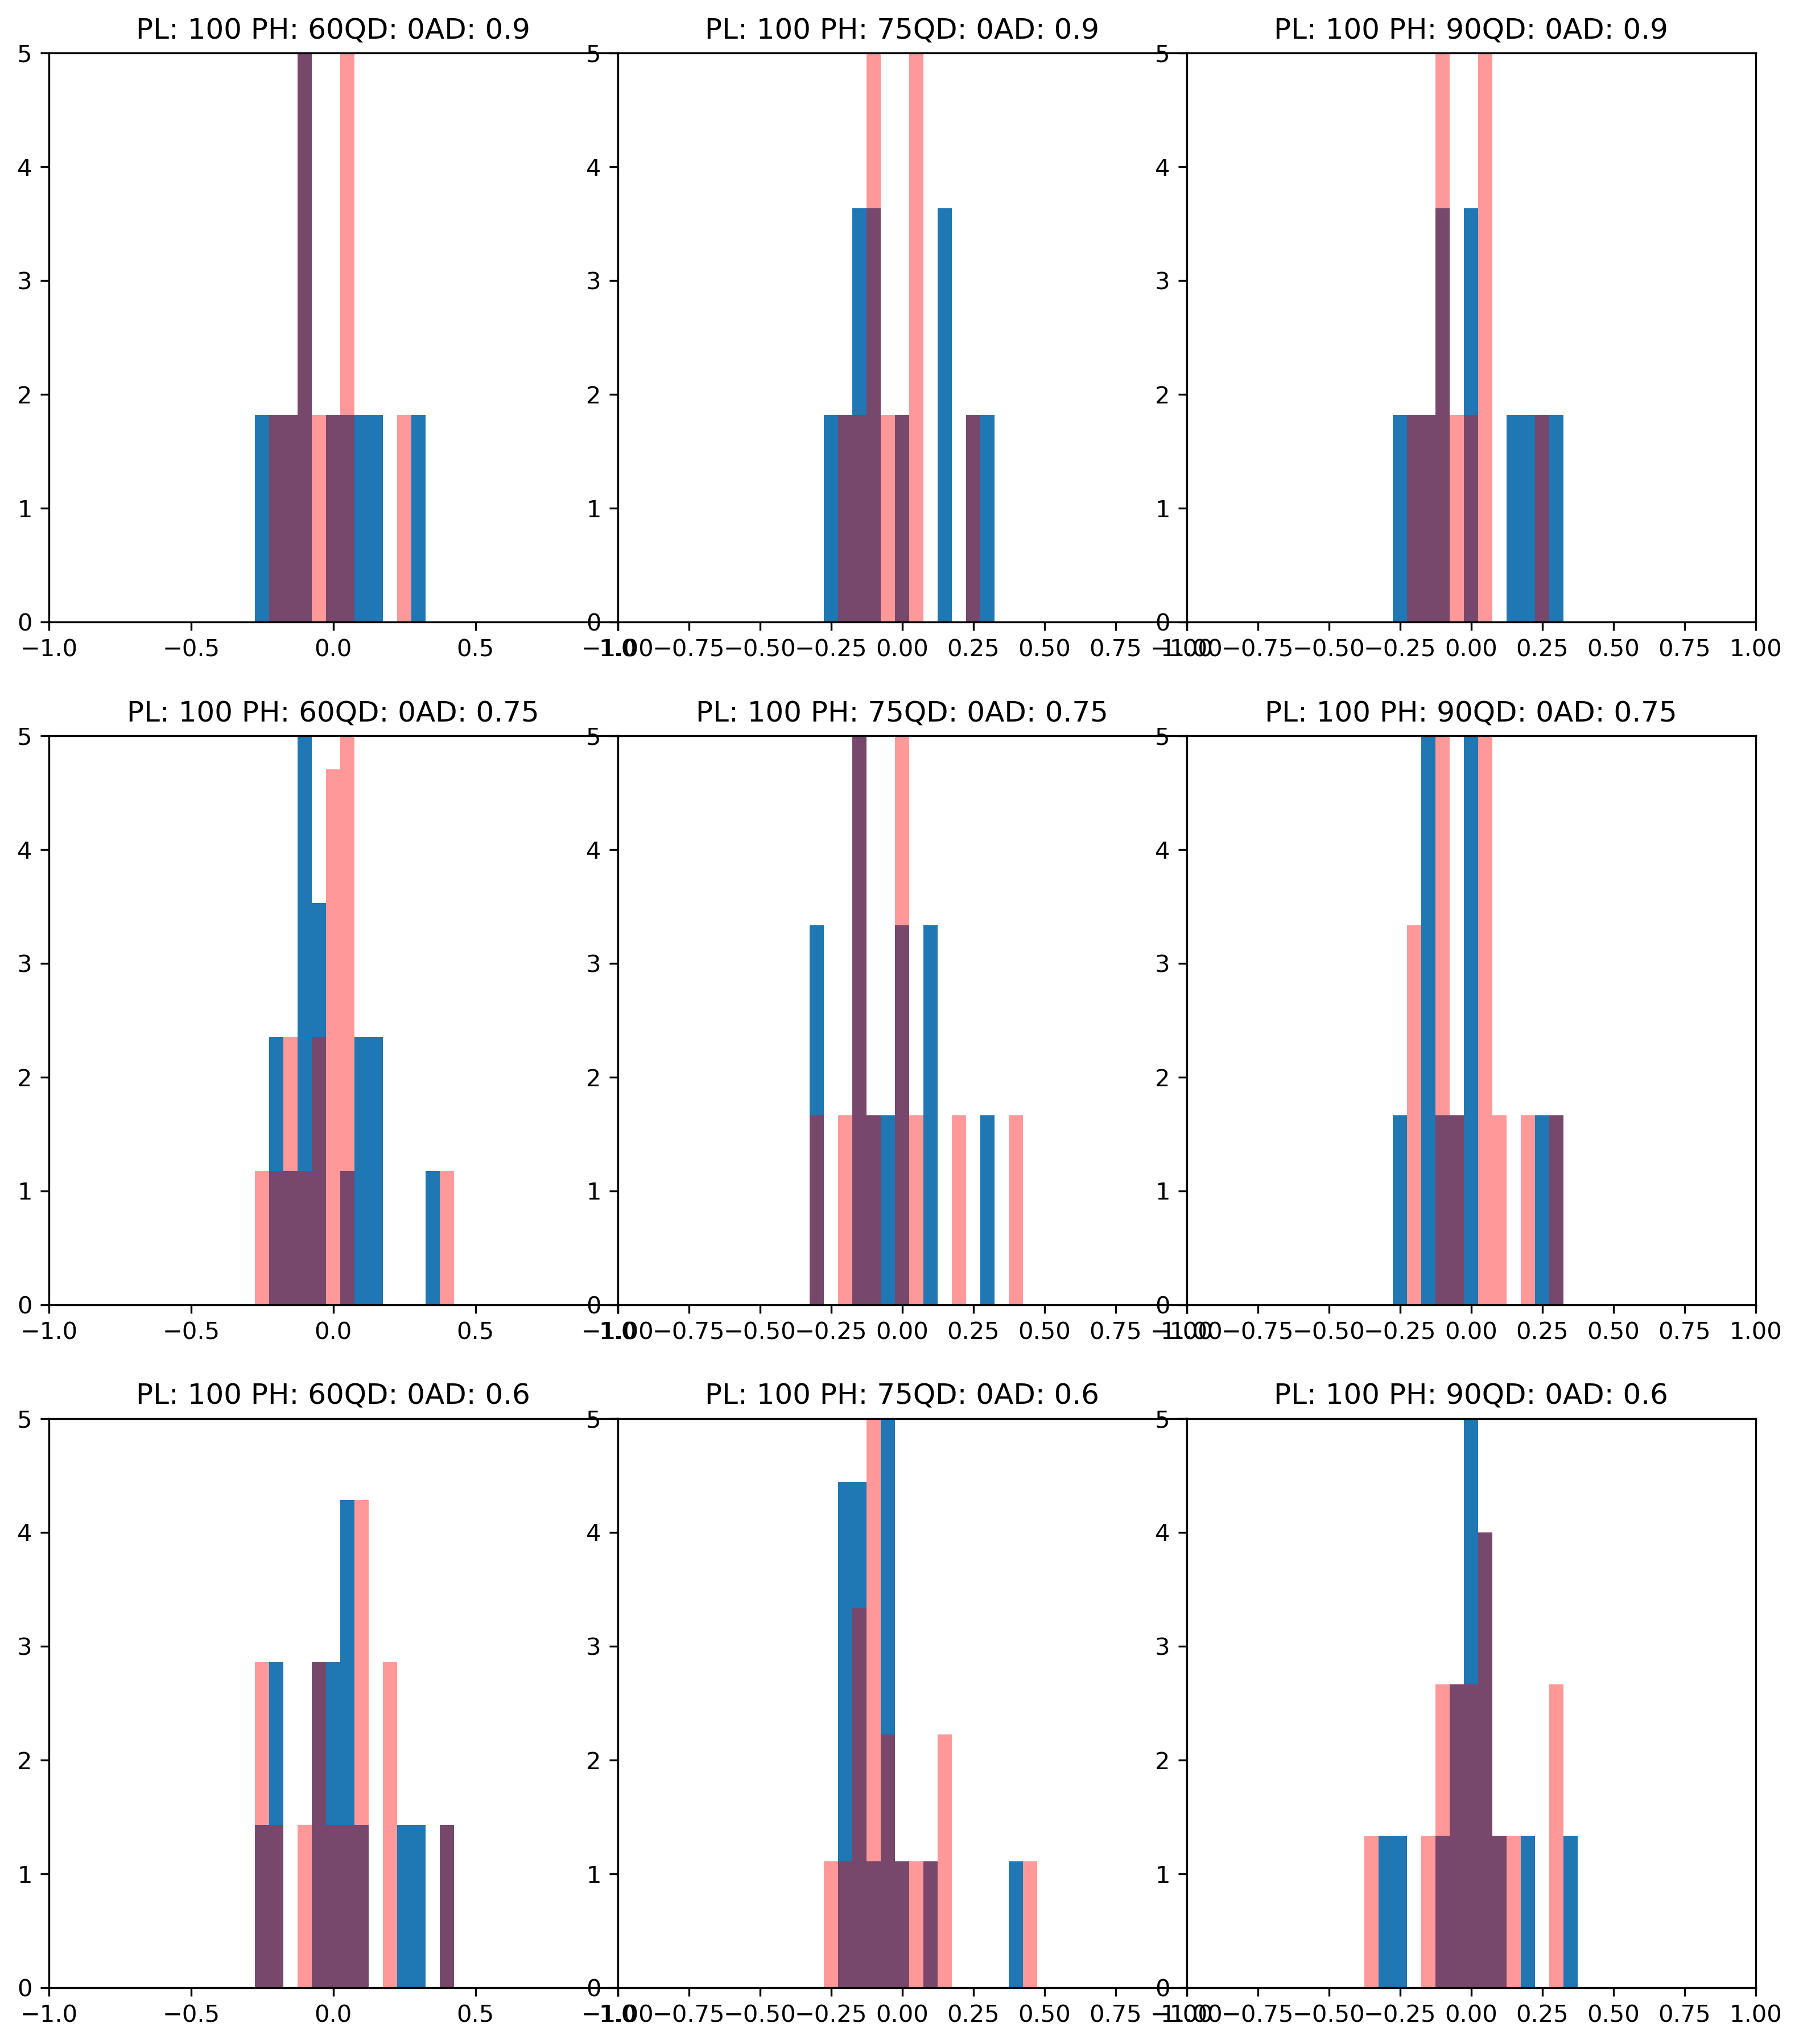

In [48]:
bins = np.arange(-1.3,1.3,.05)+0.025
top = 5
left = -1
right = 1

# Size definitions
dpi = 300
pxx = 1000   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 3      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units
                                
## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)                    
                
                
# High
for ipl, pl in enumerate(PLH):
    for iph, ph in enumerate(PHH):
        for iqd, qd in enumerate(QDH):
            for iad, ad in enumerate(ADH):
                
#                 ValMask = np.isfinite(np.double(MxDf.loc[([pl],[ph],[qd],[ad]),'mneMth'].values))
#                 ValMask = np.logical_and(ValMask, MxDf.loc[([pl],[ph],[qd],[ad]),'AvThreshold']<30)  

                ValMask = (MxDf.loc[([pl],[ph],[qd],[ad]),'RiseCount']+MxDf.loc[([pl],[ph],[qd],[ad]),'DecCount'])>5
                ValMask = np.logical_and(ValMask, MxDf.loc[([pl],[ph],[qd],[ad]),'AvThreshold']<30)  
                
                print('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad) + ' Th>30')
                print(np.round(np.mean(np.abs(MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values[ValMask])),decimals=3))        
                print(np.round(np.mean(np.abs(MxDf.loc[([pl],[ph],[qd],[ad]),'mneMth'].values[ValMask])),decimals=3))        
                
                n = (nph*(iad)+iph)
                ax1 = fig.add_axes([ppadh + iph*(pxx/fszh+ppadh2), ppadv + iad*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], label= 'b'+str(n))
                
#                 ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values[ValMask]), density = True, bins = bins)
                ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values[ValMask]), density = True, bins = bins)
                ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'mneMth'].values[ValMask]), density = True, bins = bins, color = 'r', alpha = 0.4)

                ax1.set_title('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad))                
                ax1.set_ylim(top = top, bottom = 0)
                ax1.set_xlim(right = right, left = left)
                

               
                


In [34]:
np.sum((MxDf.loc[([pl],[ph],[qd],[ad]),'RiseCount']+MxDf.loc[([pl],[ph],[qd],[ad]),'DecCount'])>2)

125

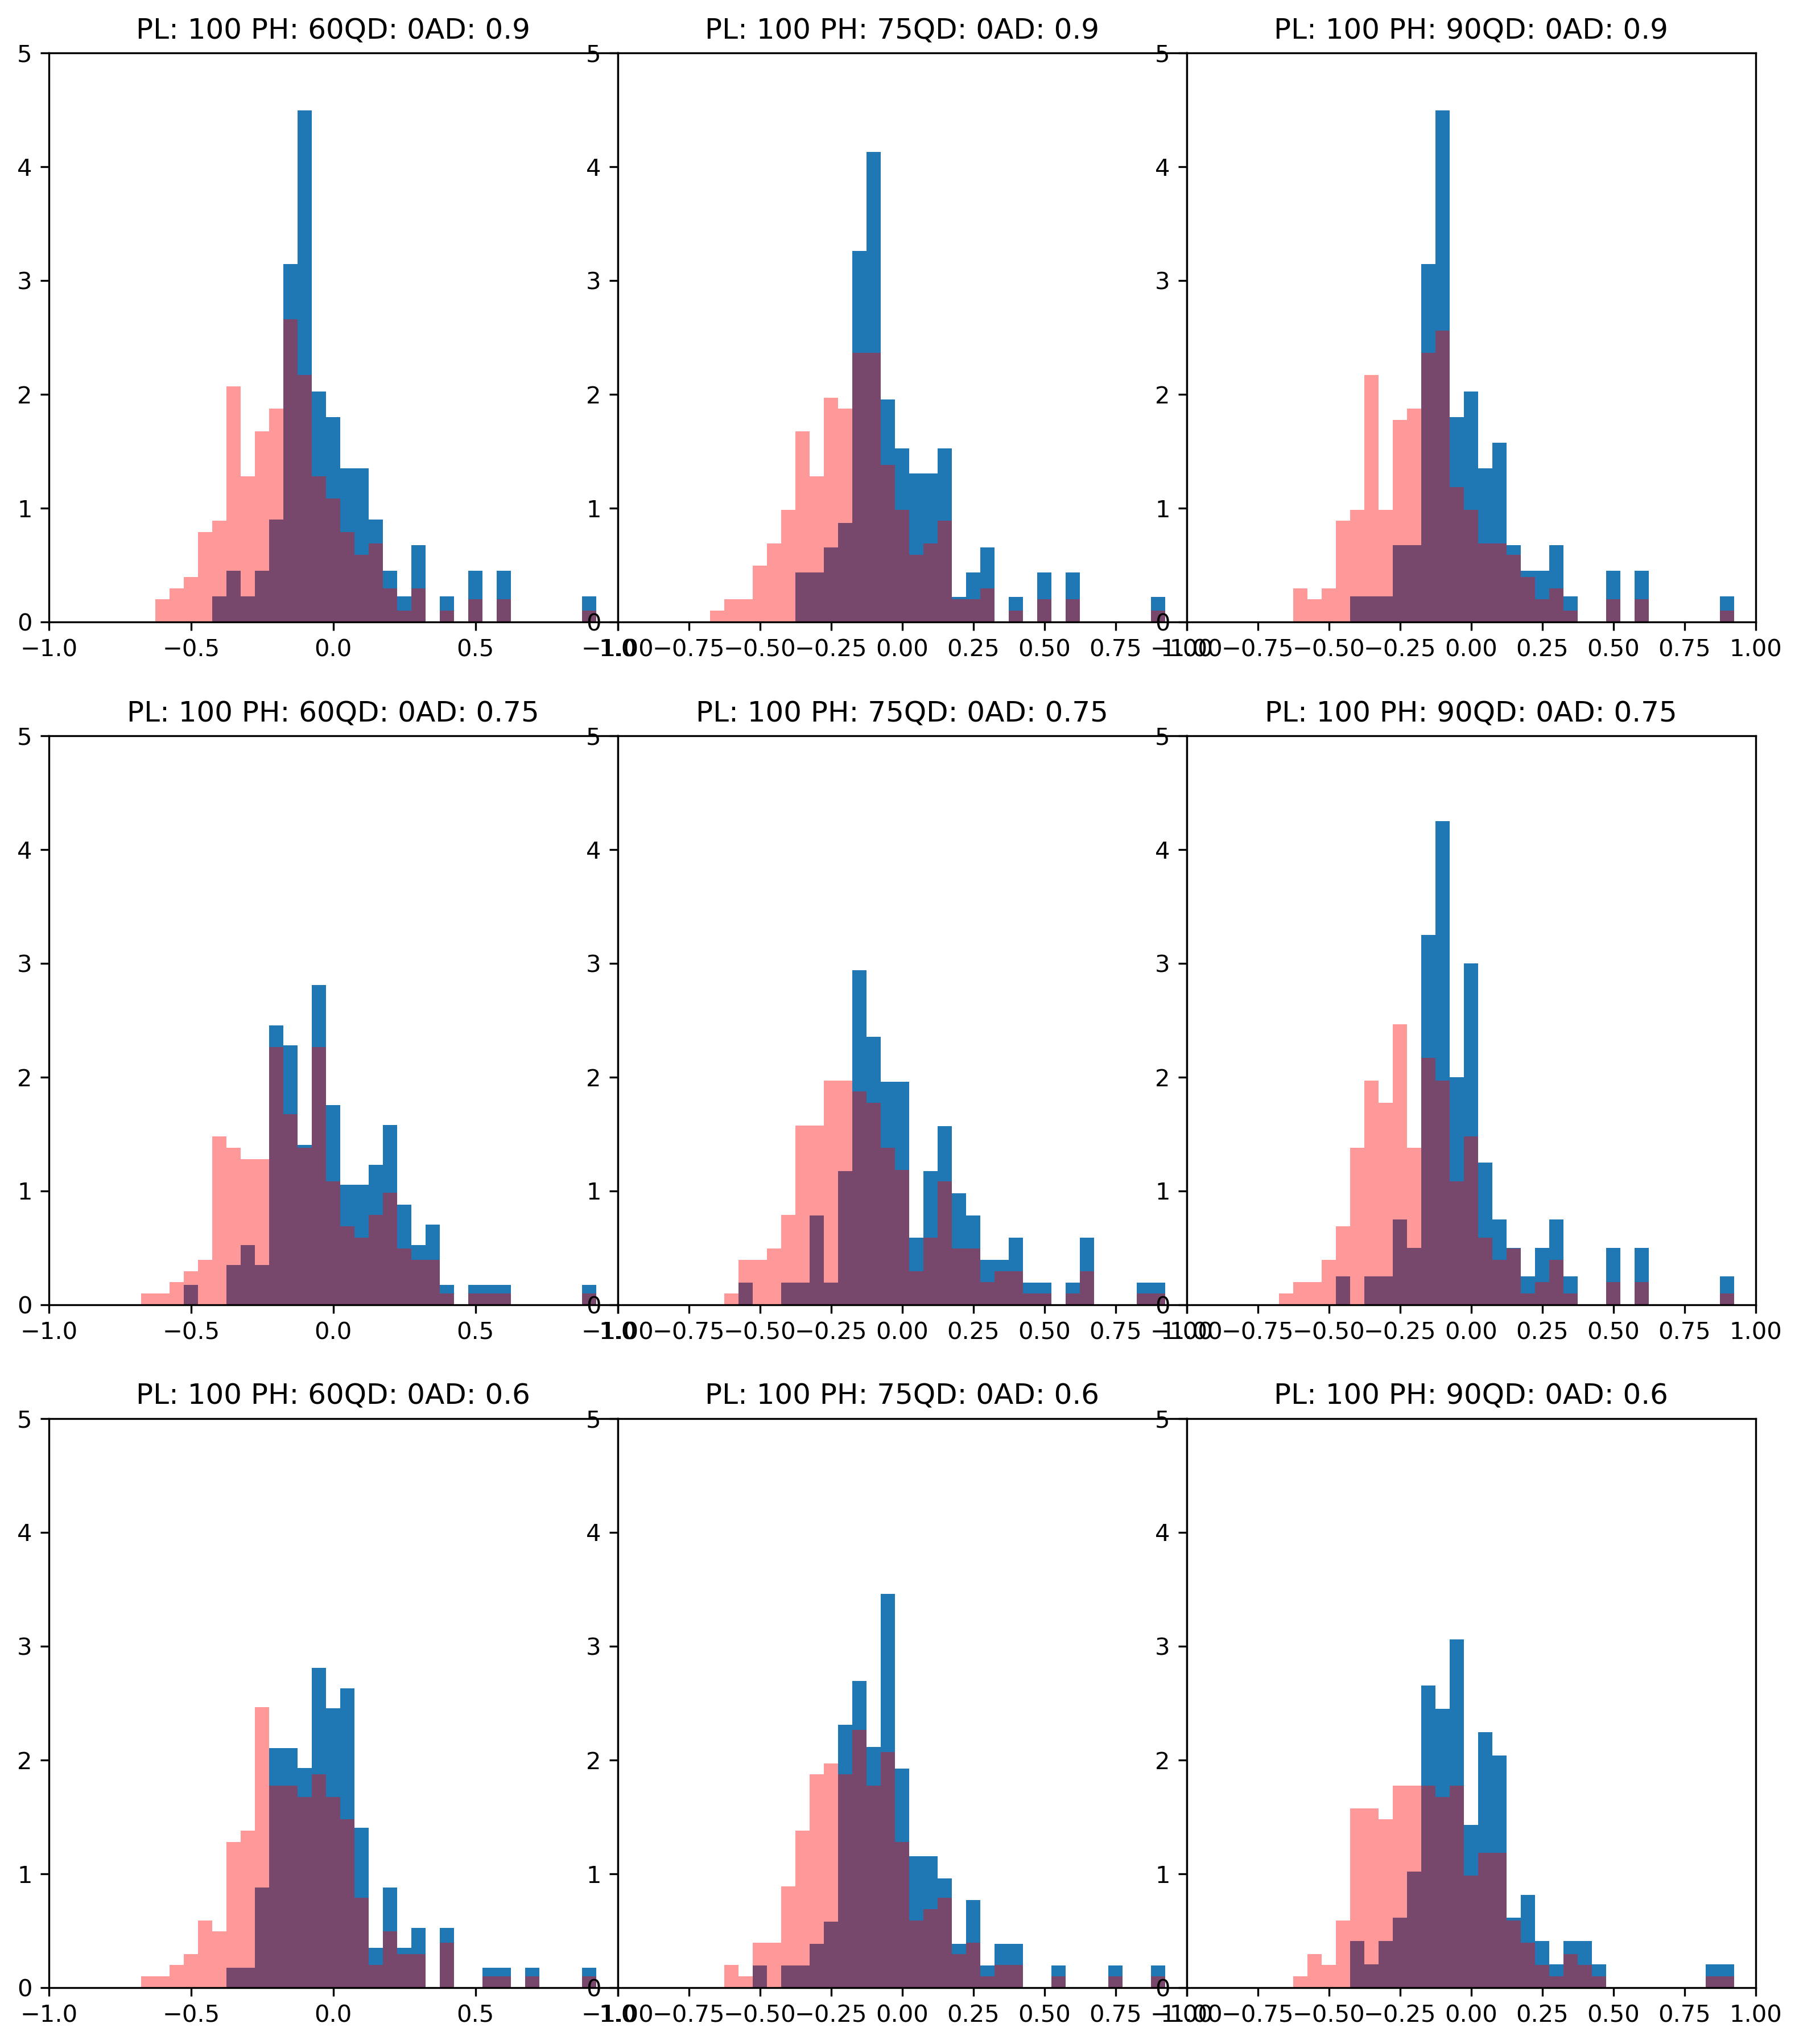

In [6]:
bins = np.arange(-1.3,1.3,.05)+0.025
top = 5
left = -1
right = 1

# Size definitions
dpi = 300
pxx = 1000   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 3      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units
                                
## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)                    
                
                
# High
for ipl, pl in enumerate(PLH):
    for iph, ph in enumerate(PHH):
        for iqd, qd in enumerate(QDH):
            for iad, ad in enumerate(ADH):
                
                ValMask = np.isfinite(np.double(MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values))
                ValMask = np.logical_and(ValMask, MxDf.loc[([pl],[ph],[qd],[ad]),'AvThreshold']<30)  
                
                n = (nph*(iad)+iph)
                ax1 = fig.add_axes([ppadh + iph*(pxx/fszh+ppadh2), ppadv + iad*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], label= 'b'+str(n))
                
                ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values[ValMask]), density = True, bins = bins)
                ax1.set_title('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad))                
                ax1.set_ylim(top = top, bottom = 0)
                ax1.set_xlim(right = right, left = left)
                

                ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'mneSth'].values), density = True, bins = bins, color = 'r', alpha = 0.4)
               
                


In [7]:
MxDf['AbsmreSth'] = np.abs(MxDf['mreSth'])

minAbsmreSth = MxDf['AbsmreSth'].min(level='Observer')

# Referencia
MxDf.loc[([0],[0],[0],[0]),'AbsmreSthR'] = MxDf.loc[([0],[0],[0],[0]),'AbsmreSth'] - minAbsmreSth

# Low
print('Low Runs')
print('--------')
for ipl, pl in enumerate(PLL):
    for iph, ph in enumerate(PHL):
        for iqd, qd in enumerate(QDL):
            for iad, ad in enumerate(ADL):
                
                MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmreSthR'] = MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmreSth'] - minAbsmreSth
                ValMask = np.isfinite(np.double(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmreSthR'].values))
                
                print('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad))
                print(np.round(np.mean(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmreSthR'].values[ValMask]),decimals=2))

# High
print('')
print('High Runs')
print('--------')
for ipl, pl in enumerate(PLH):
    for iph, ph in enumerate(PHH):
        for iqd, qd in enumerate(QDH):
            for iad, ad in enumerate(ADH):
                
                MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmreSthR'] = MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmreSth'] - minAbsmreSth
                ValMask = np.isfinite(np.double(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmreSthR'].values))
                
                print('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad))
                print(np.round(np.mean(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmreSthR'].values[ValMask]),decimals=2))

print(' ')                
print('Reference')
print('--------')
ValMask = np.isfinite(np.double(MxDf.loc[([0],[0],[0],[0]),'AbsmreSthR'].values))
print(np.round(np.mean(MxDf.loc[([0],[0],[0],[0]),'AbsmreSthR'].values[ValMask]),decimals=2))


Low Runs
--------
PL: 90 PH: 100QD: 0.1AD: 1.0
0.14
PL: 90 PH: 100QD: 0.25AD: 1.0
0.14
PL: 90 PH: 100QD: 0.4AD: 1.0
0.14

High Runs
--------
PL: 100 PH: 60QD: 0AD: 0.6
0.12
PL: 100 PH: 60QD: 0AD: 0.75
0.13
PL: 100 PH: 60QD: 0AD: 0.9
0.14
PL: 100 PH: 75QD: 0AD: 0.6
0.12
PL: 100 PH: 75QD: 0AD: 0.75
0.15
PL: 100 PH: 75QD: 0AD: 0.9
0.14
PL: 100 PH: 90QD: 0AD: 0.6
0.13
PL: 100 PH: 90QD: 0AD: 0.75
0.15
PL: 100 PH: 90QD: 0AD: 0.9
0.14
 
Reference
--------
0.14



Low Runs
--------
PL: 90 PH: 100QD: 0.1AD: 1.0
0.01
PL: 90 PH: 100QD: 0.25AD: 1.0
0.01
PL: 90 PH: 100QD: 0.4AD: 1.0
0.01

High Runs
--------
PL: 100 PH: 60QD: 0AD: 0.6
0.063
PL: 100 PH: 60QD: 0AD: 0.75
0.089
PL: 100 PH: 60QD: 0AD: 0.9
0.075
PL: 100 PH: 75QD: 0AD: 0.6
0.07
PL: 100 PH: 75QD: 0AD: 0.75
0.114
PL: 100 PH: 75QD: 0AD: 0.9
0.079
PL: 100 PH: 90QD: 0AD: 0.6
0.072
PL: 100 PH: 90QD: 0AD: 0.75
0.073
PL: 100 PH: 90QD: 0AD: 0.9
0.078

Reference
--------
0.083


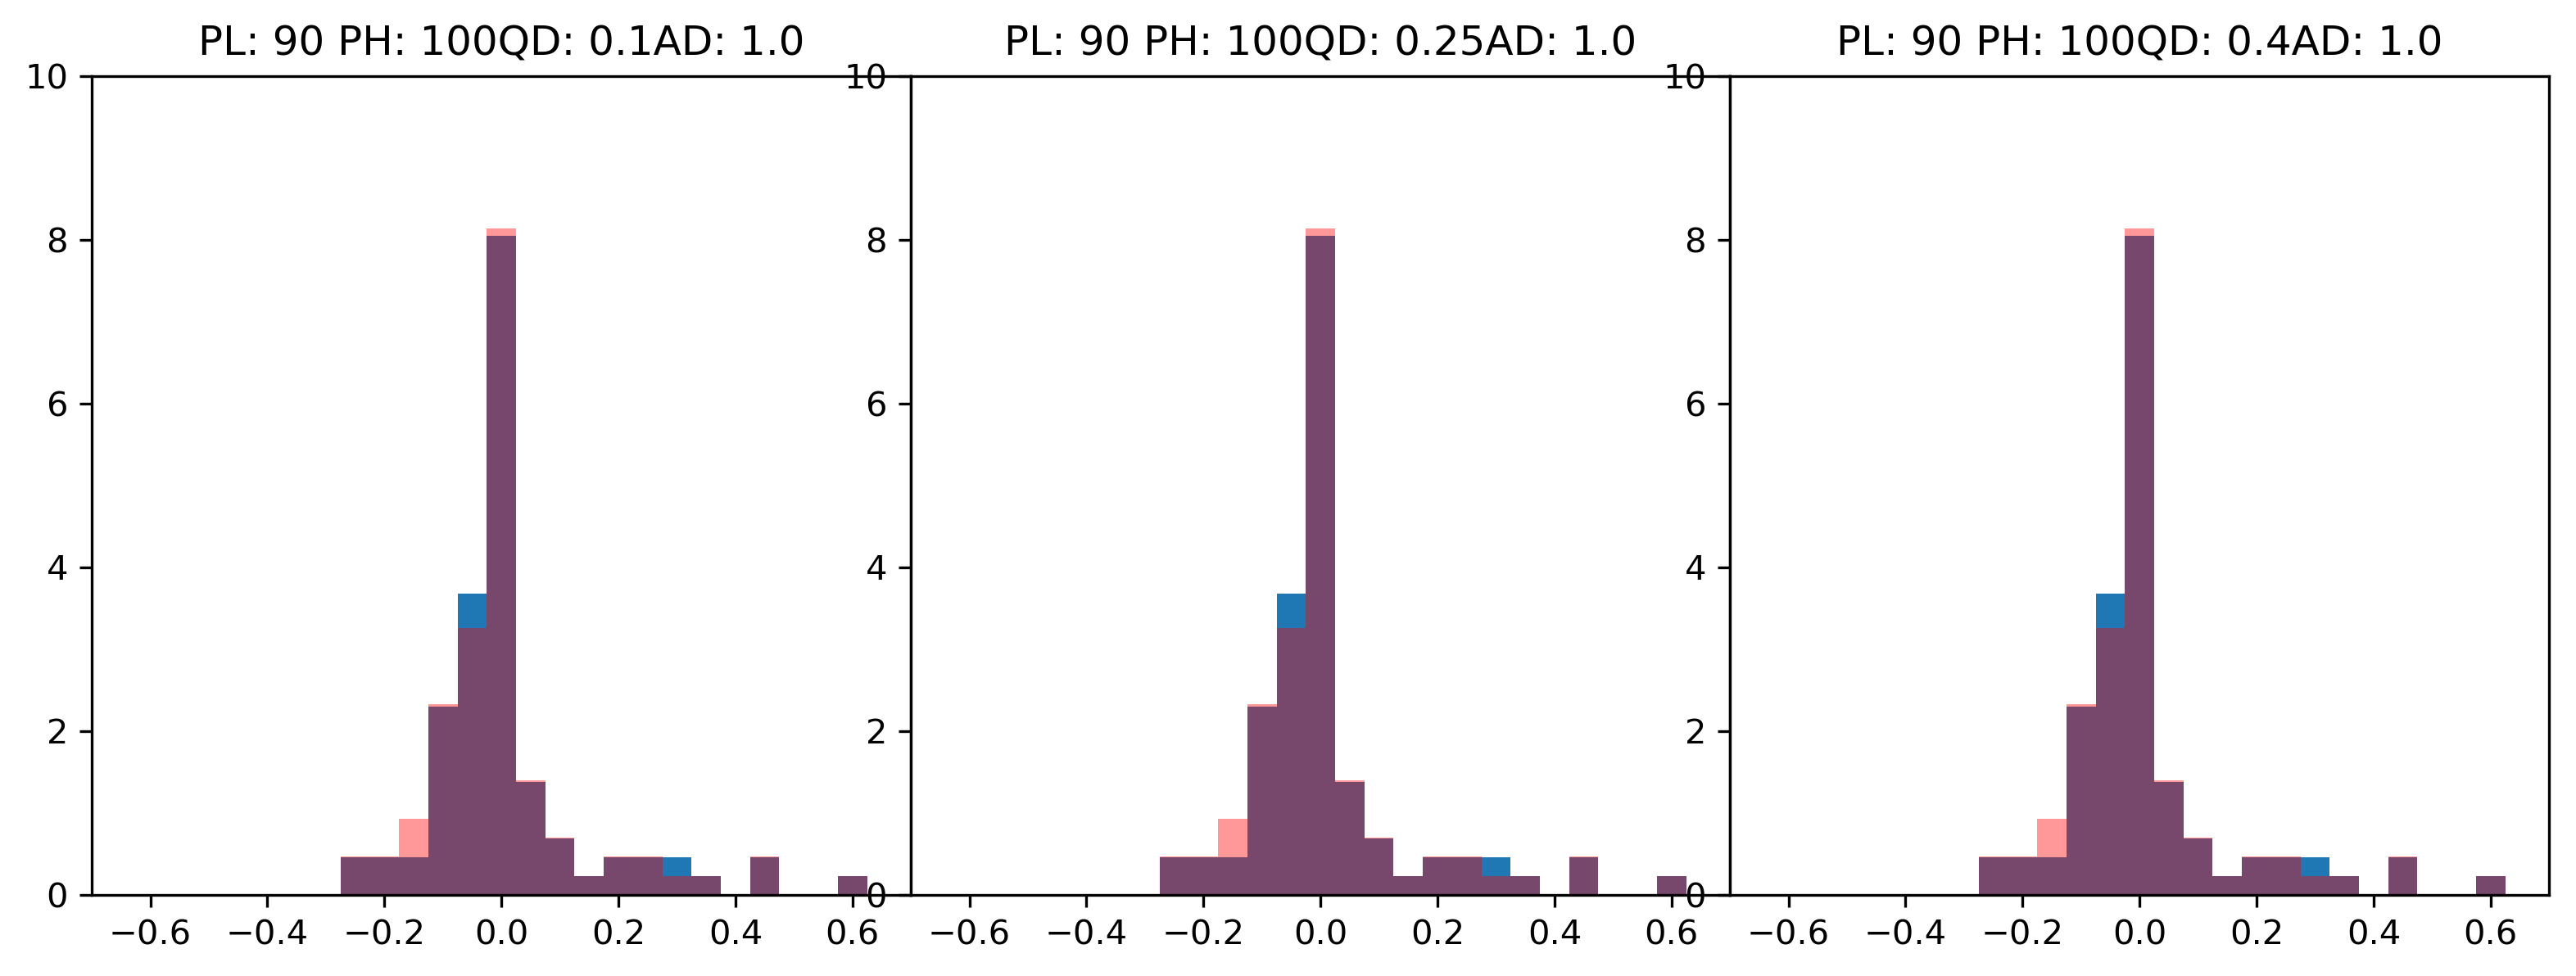

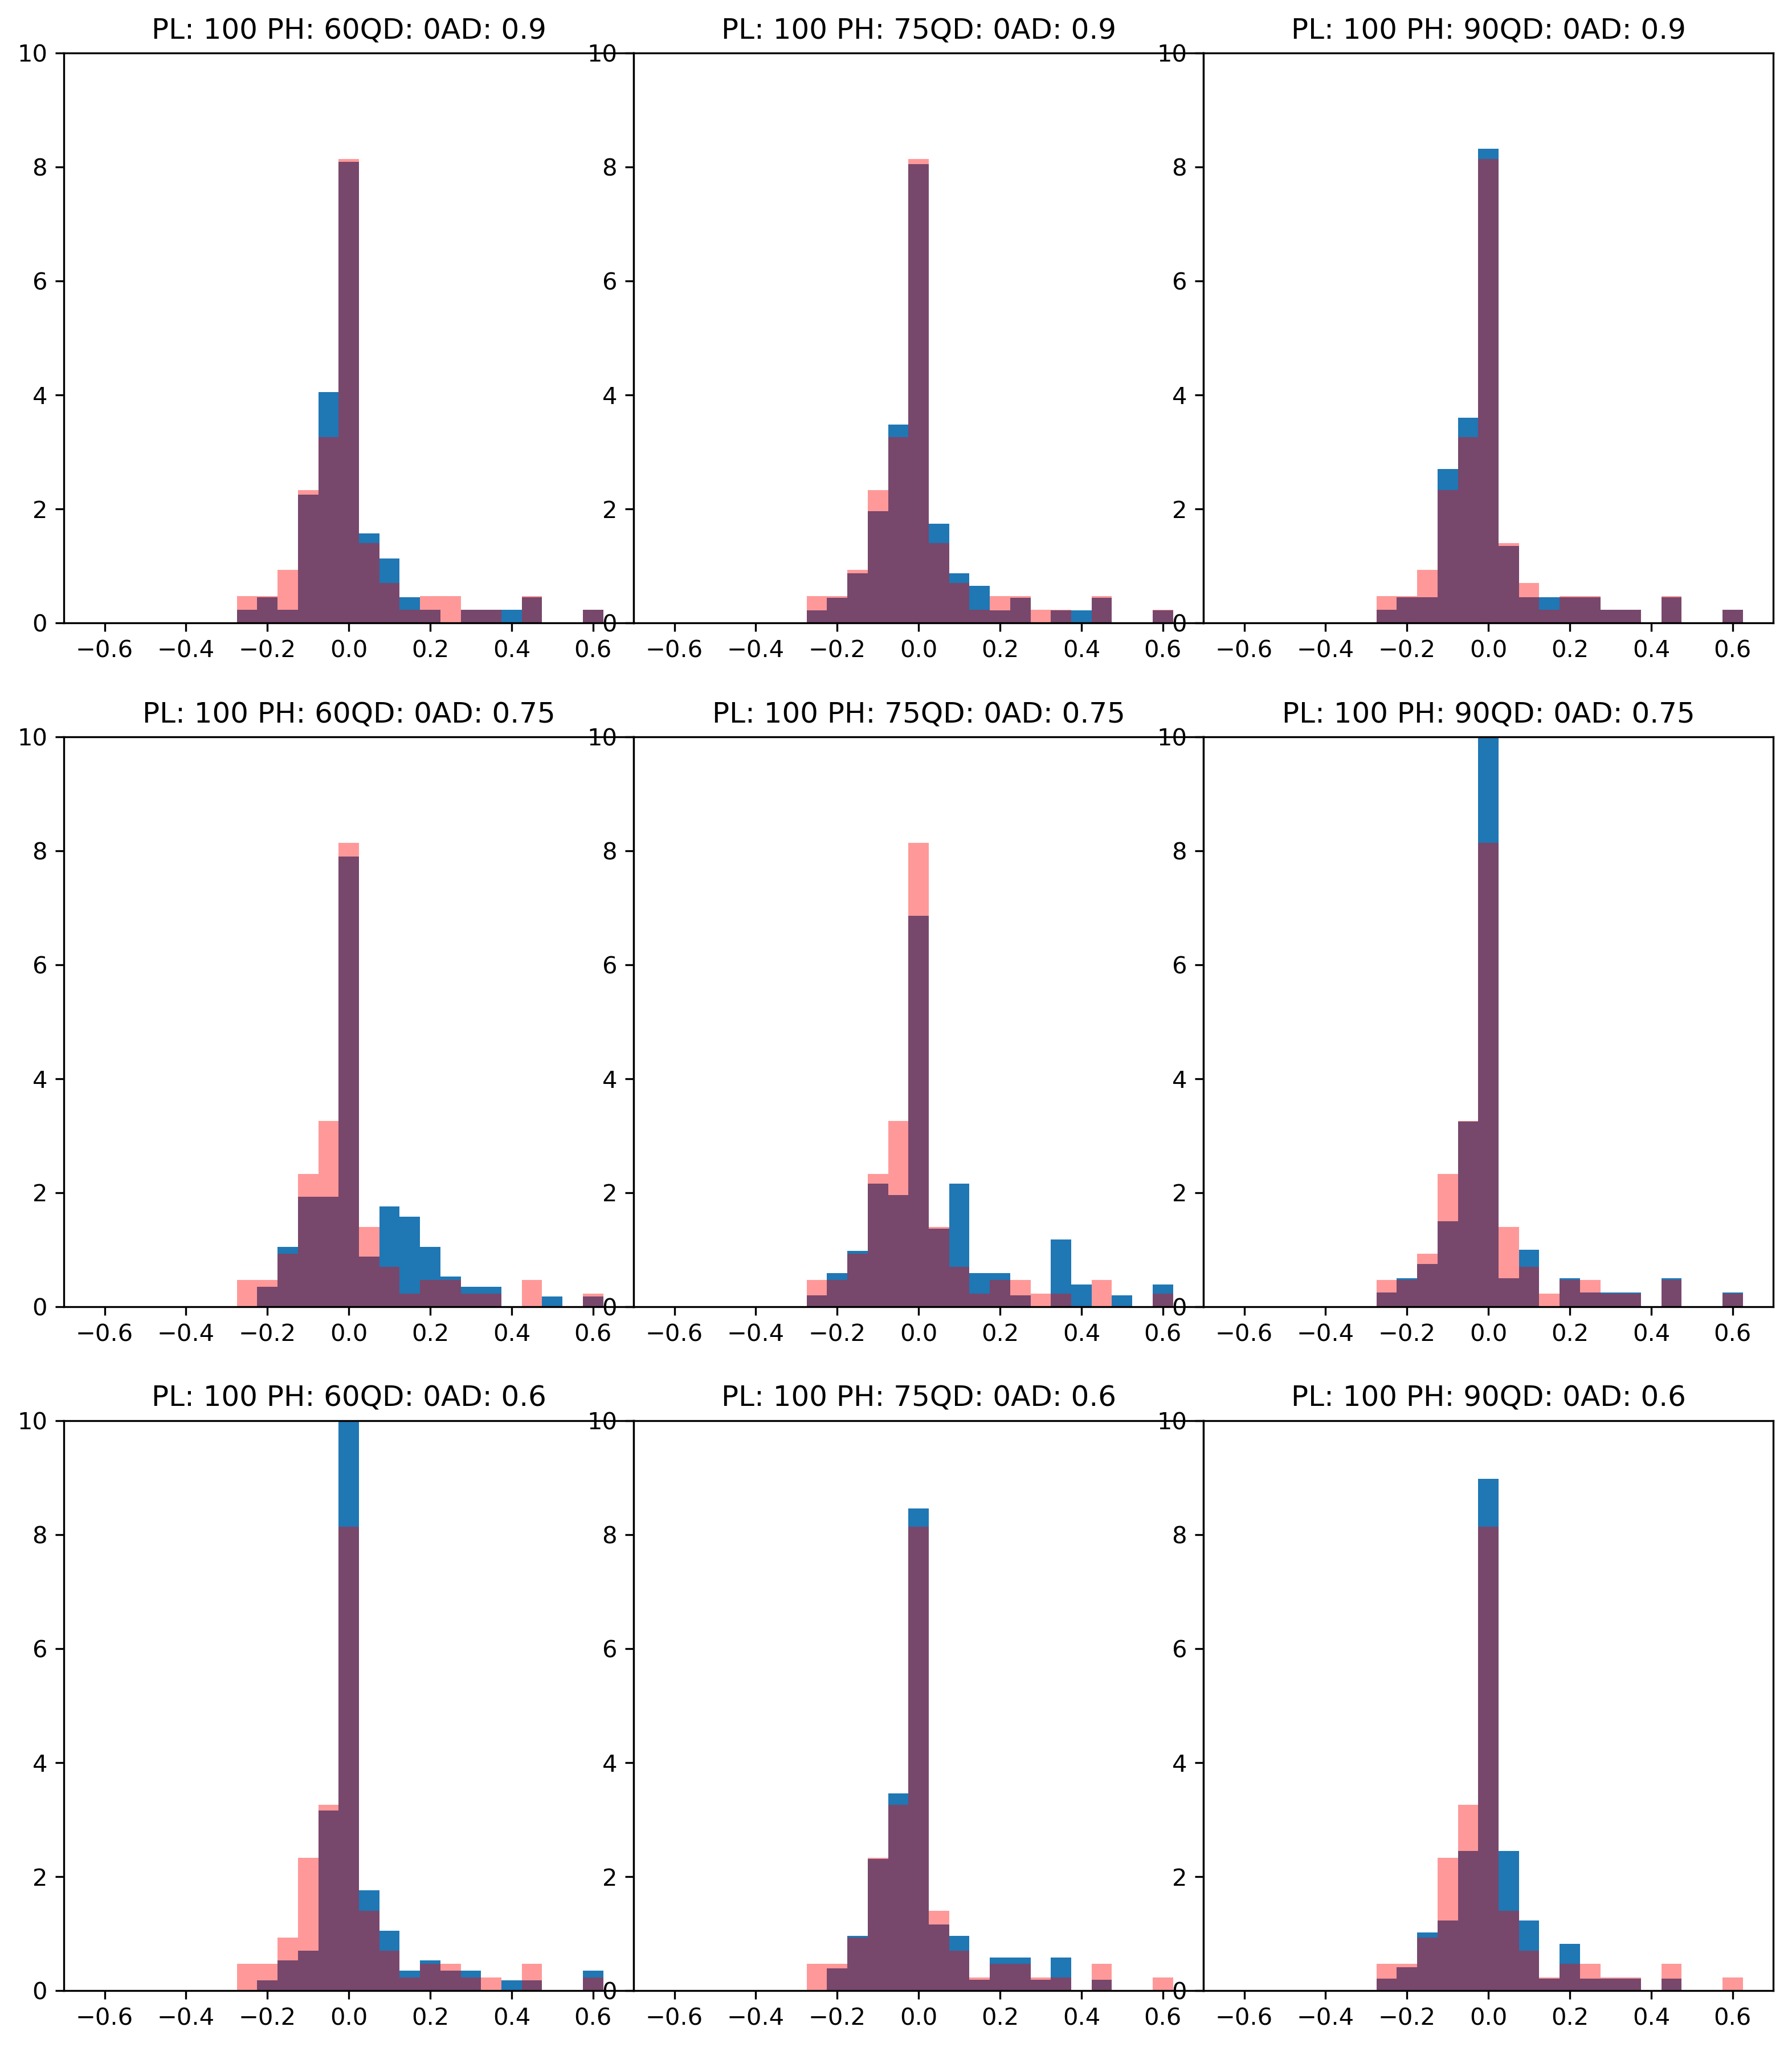

In [8]:
MxDf['AbsmneSth'] = np.abs(MxDf['mneSth'])
MxDf['Sign'] = np.sign(MxDf['mneSth'])

minAbsmneSth = MxDf['AbsmneSth'].min(level='Observer')

# Referencia
#MxDf.loc[([0],[0],[0],[0]),'AbsmneSthR'] = MxDf.loc[([0],[0],[0],[0]),'AbsmneSth'] - minAbsmneSth
MxDf.loc[([0],[0],[0],[0]),'AbsmneSthR'] = (MxDf.loc[([0],[0],[0],[0]),'AbsmneSth'] - minAbsmneSth)*MxDf.loc[([0],[0],[0],[0]),'Sign']

bins = np.arange(-1.3,1.3,.05)+0.025
top = 10
left = -0.7
right = 0.7

       




# Size definitions
dpi = 300
pxx = 1000   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 3      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units
                
## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)  

# Low
print('')
print('Low Runs')
print('--------')
for ipl, pl in enumerate(PLL):
    for iph, ph in enumerate(PHL):
        for iqd, qd in enumerate(QDL):
            for iad, ad in enumerate(ADL):
                
#                 MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmneSthR'] = MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmneSth'] - minAbsmneSth
                MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmneSthR'] = (MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmneSth'] - minAbsmneSth)*MxDf.loc[([pl],[ph],[qd],[ad]),'Sign']
                ValMask = np.isfinite(np.double(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmneSthR'].values))
                ValMask = np.logical_and(ValMask, MxDf.loc[([pl],[ph],[qd],[ad]),'AvThreshold']<30)        
                
                print('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad))
                print(np.round(np.mean(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmneSthR'].values[ValMask]), decimals=2))
                
                n = (nph*(iqd)+ipl)
                ax1 = fig.add_axes([ppadh + iqd*(pxx/fszh+ppadh2), ppadv + ipl*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], label= 'b'+str(n))
                
                ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmneSthR'].values[ValMask]), density = True, bins = bins)
                ax1.set_title('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad))                
                ax1.set_ylim(top = top, bottom = 0)
                ax1.set_xlim(right = right, left = left)
                
                ValMask = np.isfinite(np.double(MxDf.loc[([0],[0],[0],[0]),'AbsmneSthR'].values))
                ValMask = np.isfinite(np.double(MxDf.loc[([0],[0],[0],[0]),'AbsmneSthR'].values))
                ValMask = np.logical_and(ValMask, MxDf.loc[([0],[0],[0],[0]),'AvThreshold']<30)    
                ax1.hist(np.vstack(MxDf.loc[([0],[0],[0],[0]),'AbsmneSthR'].values[ValMask]), density = True, bins = bins, color = 'r', alpha = 0.4)
                



                
## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)                    
                
                
# High
print('')
print('High Runs')
print('--------')
for ipl, pl in enumerate(PLH):
    for iph, ph in enumerate(PHH):
        for iqd, qd in enumerate(QDH):
            for iad, ad in enumerate(ADH):
                
#                 MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmneSthR'] = MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmneSth'] - minAbsmneSth
                MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmneSthR'] = (MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmneSth'] - minAbsmneSth)*MxDf.loc[([pl],[ph],[qd],[ad]),'Sign']
                ValMask = np.isfinite(np.double(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmneSthR'].values))
                ValMask = np.logical_and(ValMask, MxDf.loc[([pl],[ph],[qd],[ad]),'AvThreshold']<30)
                
                print('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad))
                print(np.round(np.mean(np.abs(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmneSthR'].values[ValMask])),decimals=3))
                
                n = (nph*(iad)+iph)
                ax1 = fig.add_axes([ppadh + iph*(pxx/fszh+ppadh2), ppadv + iad*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], label= 'b'+str(n))
                
                ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsmneSthR'].values[ValMask]), density = True, bins = bins)
                ax1.set_title('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad))                
                ax1.set_ylim(top = top, bottom = 0)
                ax1.set_xlim(right = right, left = left)
                
                ValMask = np.isfinite(np.double(MxDf.loc[([0],[0],[0],[0]),'AbsmneSthR'].values))
                ValMask = np.isfinite(np.double(MxDf.loc[([0],[0],[0],[0]),'AbsmneSthR'].values))
                ValMask = np.logical_and(ValMask, MxDf.loc[([0],[0],[0],[0]),'AvThreshold']<30)    
                ax1.hist(np.vstack(MxDf.loc[([0],[0],[0],[0]),'AbsmneSthR'].values[ValMask]), density = True, bins = bins, color = 'r', alpha = 0.4)
               
                
print('')
print('Reference')
print('--------')
ValMask = np.isfinite(np.double(MxDf.loc[([0],[0],[0],[0]),'AbsmneSthR'].values))
ValMask = np.isfinite(np.double(MxDf.loc[([0],[0],[0],[0]),'AbsmneSthR'].values))
ValMask = np.logical_and(ValMask, MxDf.loc[([0],[0],[0],[0]),'AvThreshold']<30)    
print(np.round(np.mean(np.abs(MxDf.loc[([0],[0],[0],[0]),'AbsmneSthR'].values[ValMask])),decimals=3))

In [9]:
np.sum(ValMask)

86


Reference
--------
0.14
 
Low Runs
--------
PL: 90 PH: 100QD: 0.1AD: 1.0
0.14
PL: 90 PH: 100QD: 0.25AD: 1.0
0.14
PL: 90 PH: 100QD: 0.4AD: 1.0
0.14

High Runs
--------
0
PL: 100 PH: 60QD: 0AD: 0.6
0.12
0
PL: 100 PH: 60QD: 0AD: 0.75
0.13
0
PL: 100 PH: 60QD: 0AD: 0.9
0.14
1
PL: 100 PH: 75QD: 0AD: 0.6
0.12
1
PL: 100 PH: 75QD: 0AD: 0.75
0.15
1
PL: 100 PH: 75QD: 0AD: 0.9
0.14
2
PL: 100 PH: 90QD: 0AD: 0.6
0.13
2
PL: 100 PH: 90QD: 0AD: 0.75
0.15
2
PL: 100 PH: 90QD: 0AD: 0.9
0.14


<Figure size 1100x1100 with 0 Axes>

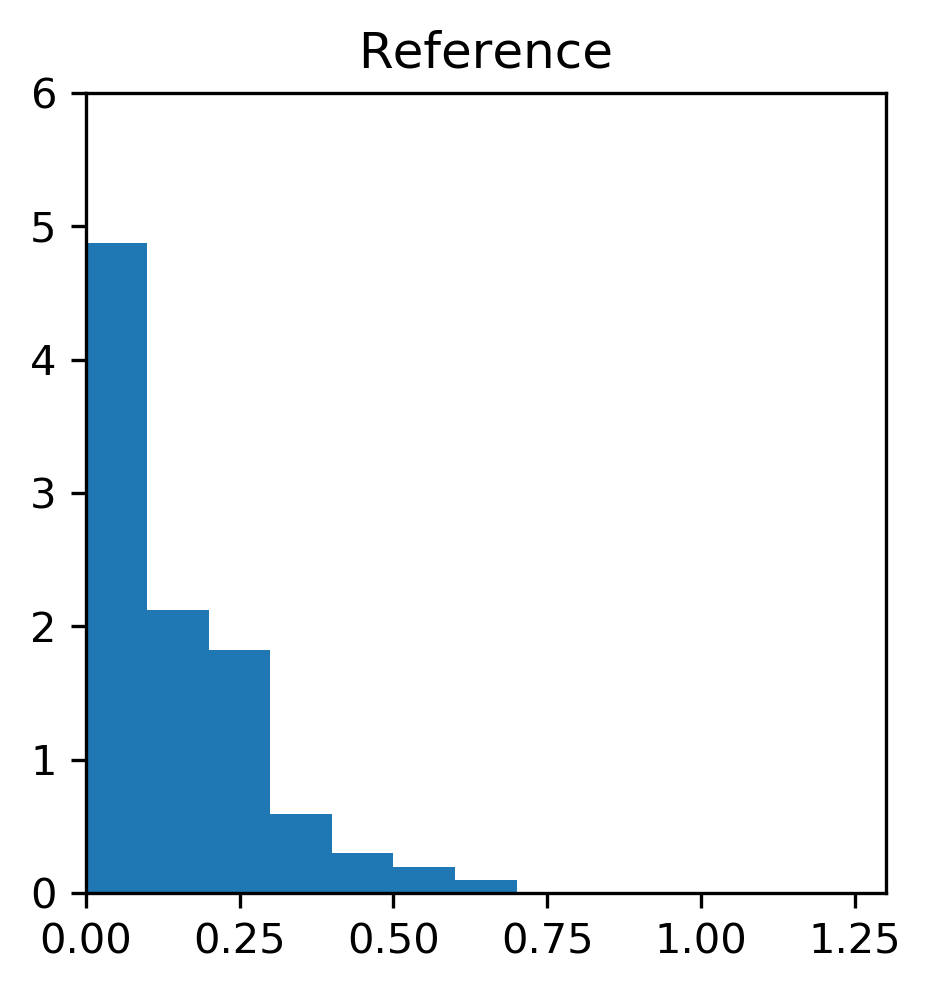

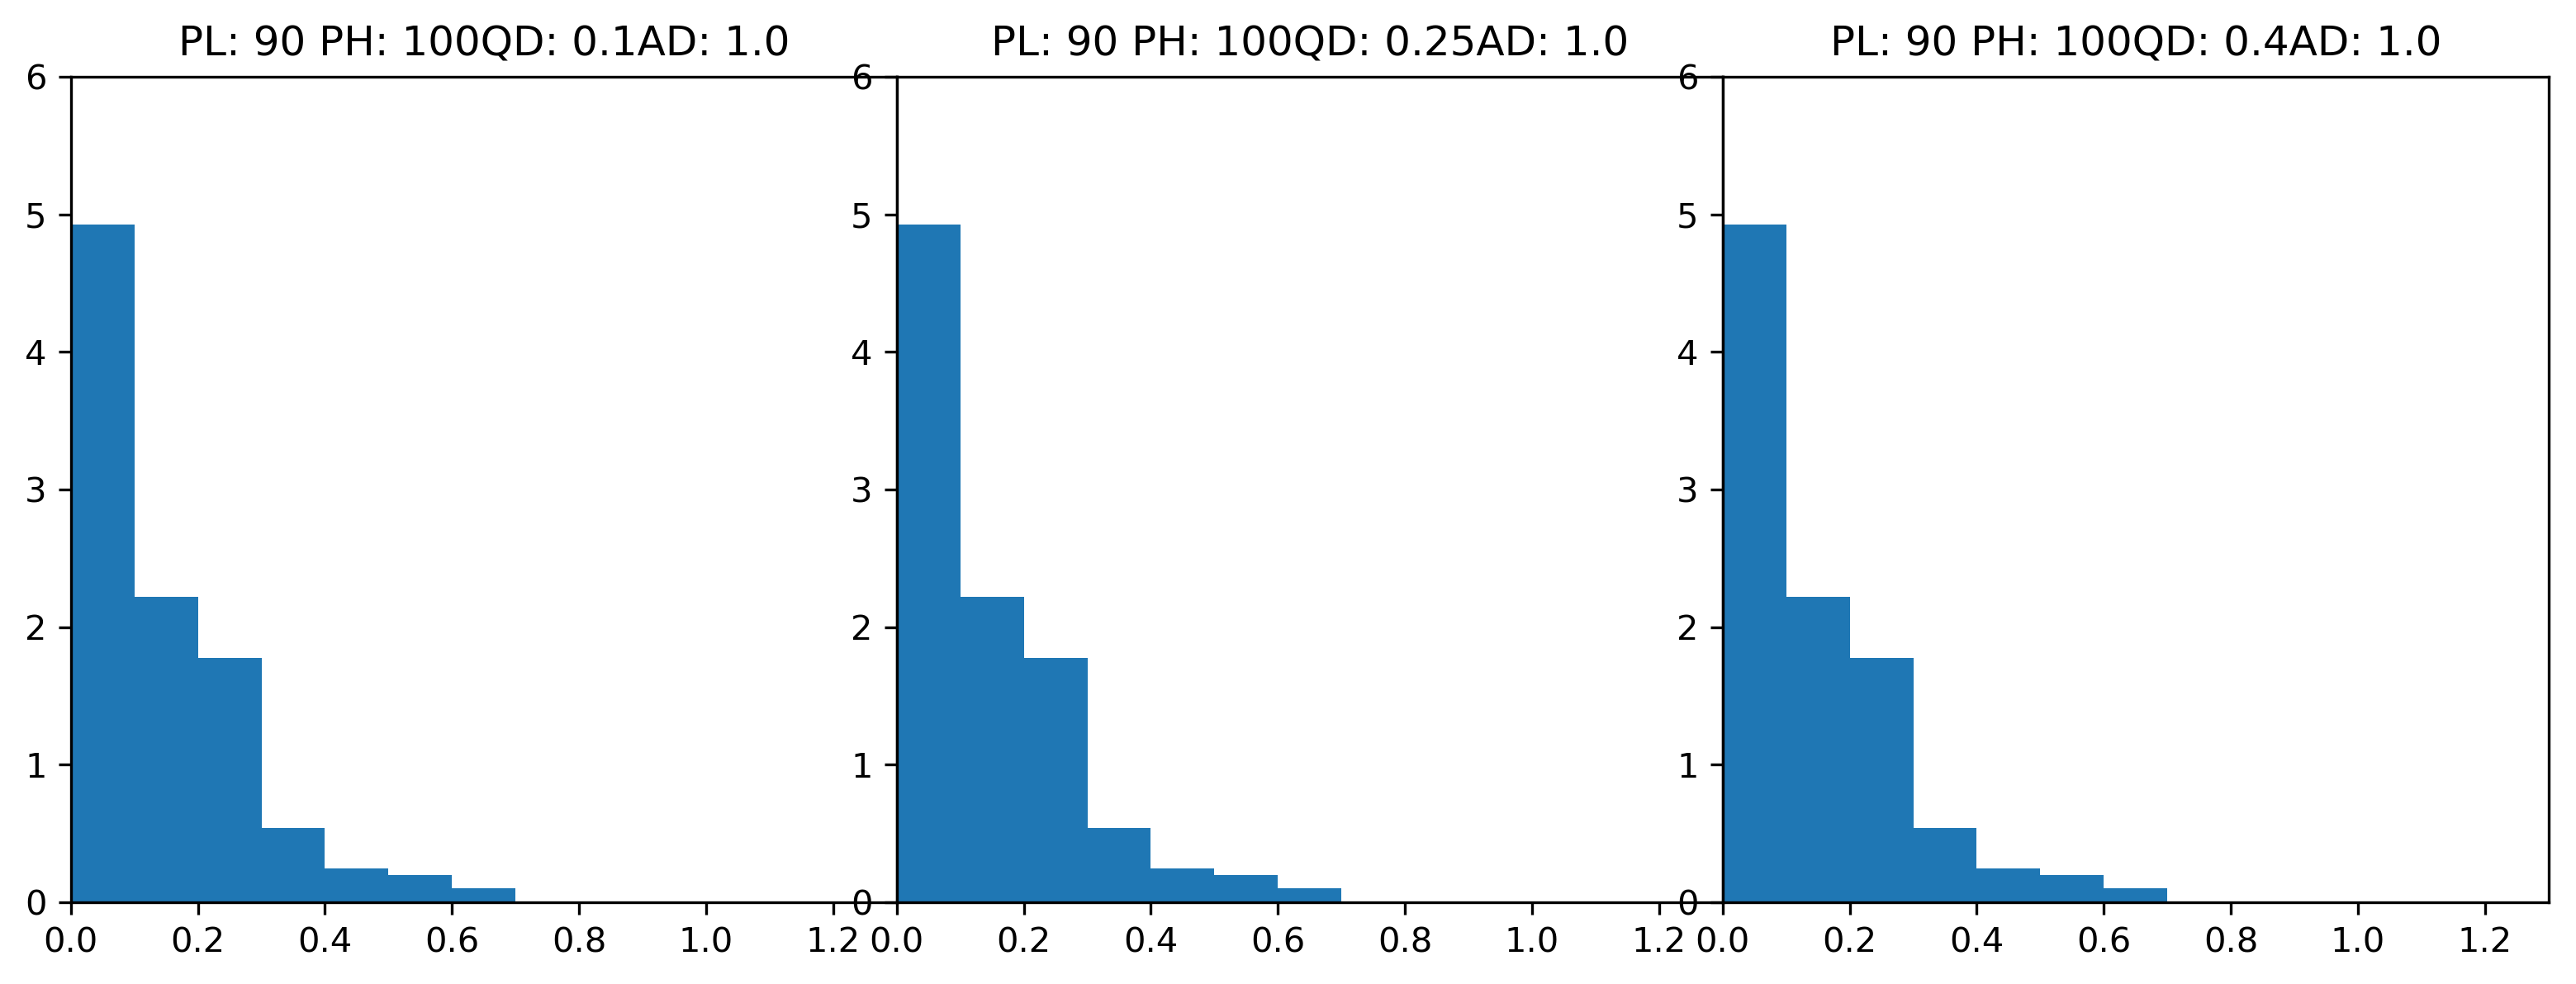

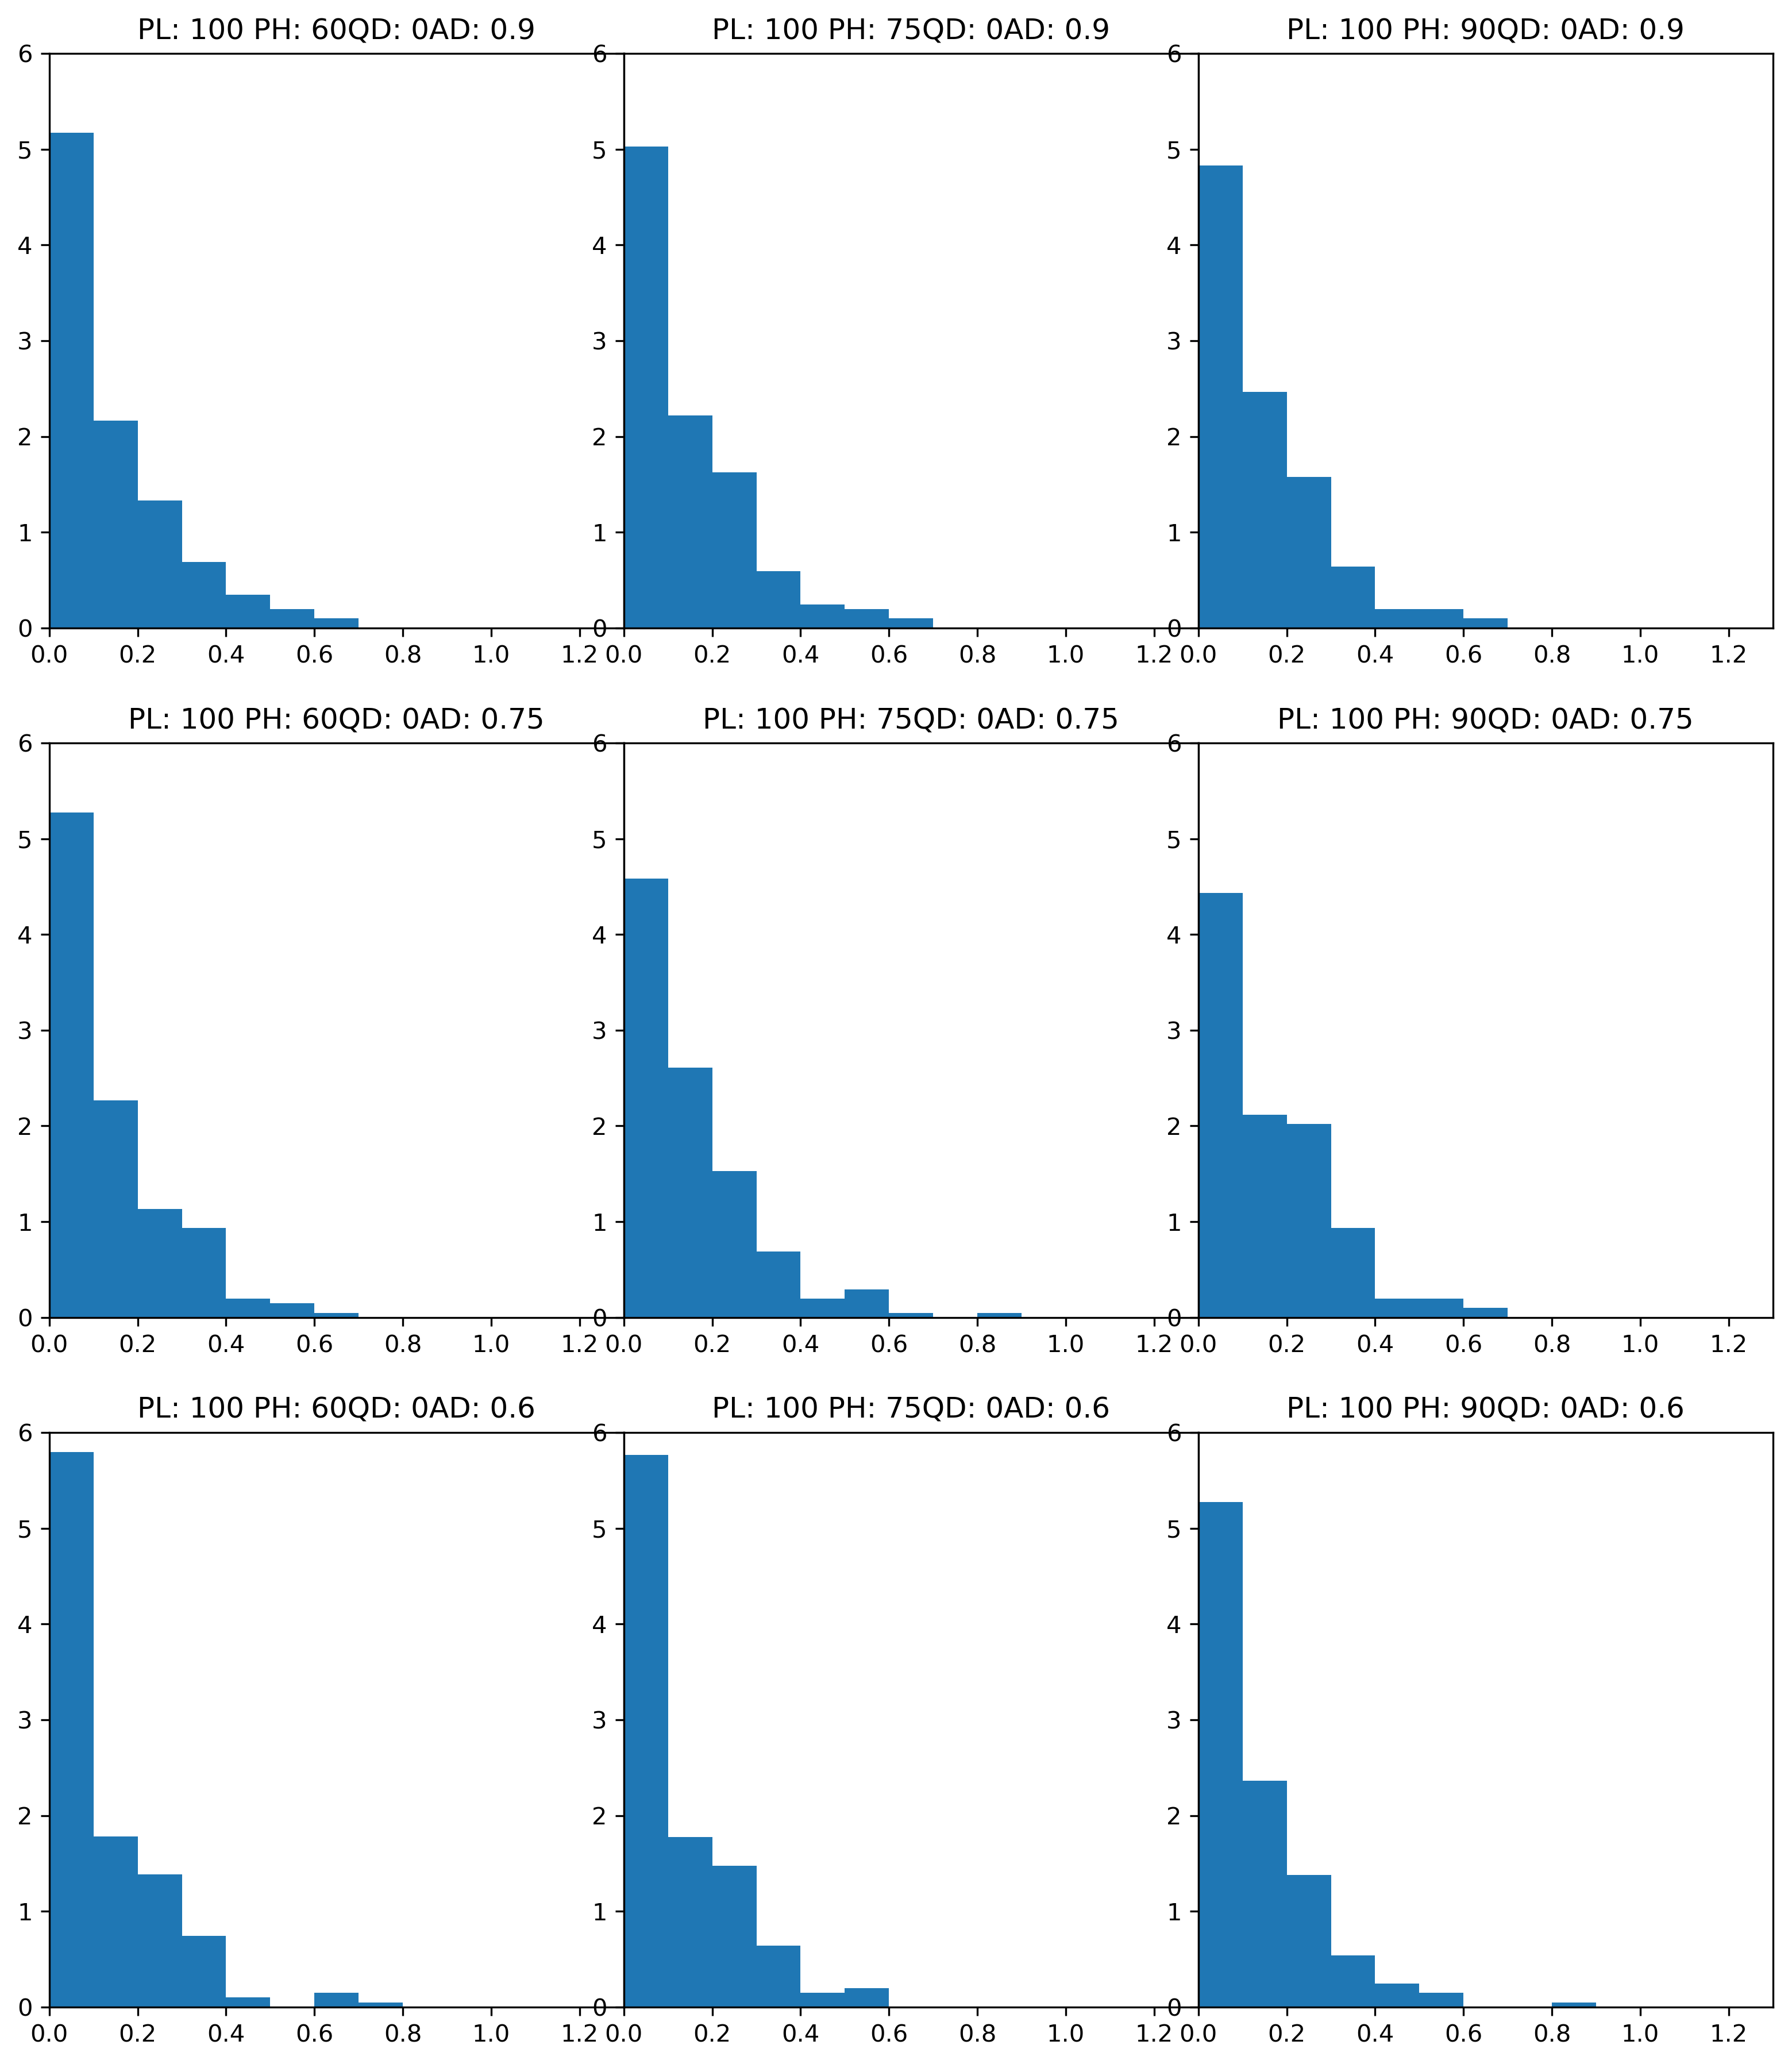

In [10]:
MxDf['AbsKSth'] = np.abs(MxDf['KSth']-1)
minAbsKSth = MxDf['AbsKSth'].min(level='Observer')


# Referencia
MxDf.loc[([0],[0],[0],[0]),'AbsKSthR'] = MxDf.loc[([0],[0],[0],[0]),'AbsKSth'] - minAbsKSth

# Size definitions
dpi = 300
pxx = 1000   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units
                
## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)  


print('')                
print('Reference')
print('--------')
ValMask = np.isfinite(np.double(MxDf.loc[([0],[0],[0],[0]),'AbsKSthR'].values))
print(np.round(np.mean(MxDf.loc[([0],[0],[0],[0]),'AbsKSthR'].values[ValMask]),decimals=2))

fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi) 
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc], label= 'b'+str(n))

ax1.hist(np.vstack(MxDf.loc[([0],[0],[0],[0]),'AbsKSthR'].values[ValMask]), density = True, bins = np.arange(0,1.3,.1))
ax1.set_title('Reference')                
ax1.set_ylim(top = 6, bottom = 0)
ax1.set_xlim(right = 1.3, left = 0)


# Size definitions
dpi = 300
pxx = 1000   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 1    # Fraction of the panel devoted to histograms

nph = 3      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 200  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0 #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units
                
## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)  


# Low
print(' ')
print('Low Runs')
print('--------')
for ipl, pl in enumerate(PLL):
    for iph, ph in enumerate(PHL):
        for iqd, qd in enumerate(QDL):
            for iad, ad in enumerate(ADL):
                
                MxDf.loc[([pl],[ph],[qd],[ad]),'AbsKSthR'] = MxDf.loc[([pl],[ph],[qd],[ad]),'AbsKSth'] - minAbsKSth
                ValMask = np.isfinite(np.double(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsKSthR'].values))
                
                print('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad))
                print(np.round(np.mean(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsKSthR'].values[ValMask]),decimals=2))

                n = (nph*(iqd)+ipl)
                ax1 = fig.add_axes([ppadh + iqd*(pxx/fszh+ppadh2), ppadv + ipl*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], label= 'b'+str(n))
                
                ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsKSthR'].values[ValMask]), density = True, bins = np.arange(0,1.3,.1))
                ax1.set_title('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad))
                ax1.set_xlim(right = 1.3, left = 0)
                ax1.set_ylim(top = 6, bottom = 0)
                

## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)                
                

    
# High
print('')
print('High Runs')
print('--------')
for ipl, pl in enumerate(PLH):
    for iph, ph in enumerate(PHH):
        for iqd, qd in enumerate(QDH):
            for iad, ad in enumerate(ADH):
                
                print(iph)
                
                MxDf.loc[([pl],[ph],[qd],[ad]),'AbsKSthR'] = MxDf.loc[([pl],[ph],[qd],[ad]),'AbsKSth'] - minAbsKSth
                ValMask = np.isfinite(np.double(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsKSthR'].values))
                
                print('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad))
                print(np.round(np.mean(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsKSthR'].values[ValMask]),decimals=2))                

                n = (nph*(iad)+iph)
                ax1 = fig.add_axes([ppadh + iph*(pxx/fszh+ppadh2), ppadv + iad*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], label= 'b'+str(n))
                
                ax1.hist(np.vstack(MxDf.loc[([pl],[ph],[qd],[ad]),'AbsKSthR'].values[ValMask]), density = True, bins = np.arange(0,1.3,.1))
                ax1.set_title('PL: ' + str(pl) + ' PH: ' + str(ph) + 'QD: ' + str(qd) + 'AD: ' + str(ad))
                ax1.set_xlim(right = 1.3, left = 0)
                ax1.set_ylim(top = 6, bottom = 0)
                


(array([23., 32., 31., 27., 26., 27., 14., 11.,  6.,  6.]),
 array([ 0. ,  9.9, 19.8, 29.7, 39.6, 49.5, 59.4, 69.3, 79.2, 89.1, 99. ]),
 <a list of 10 Patch objects>)

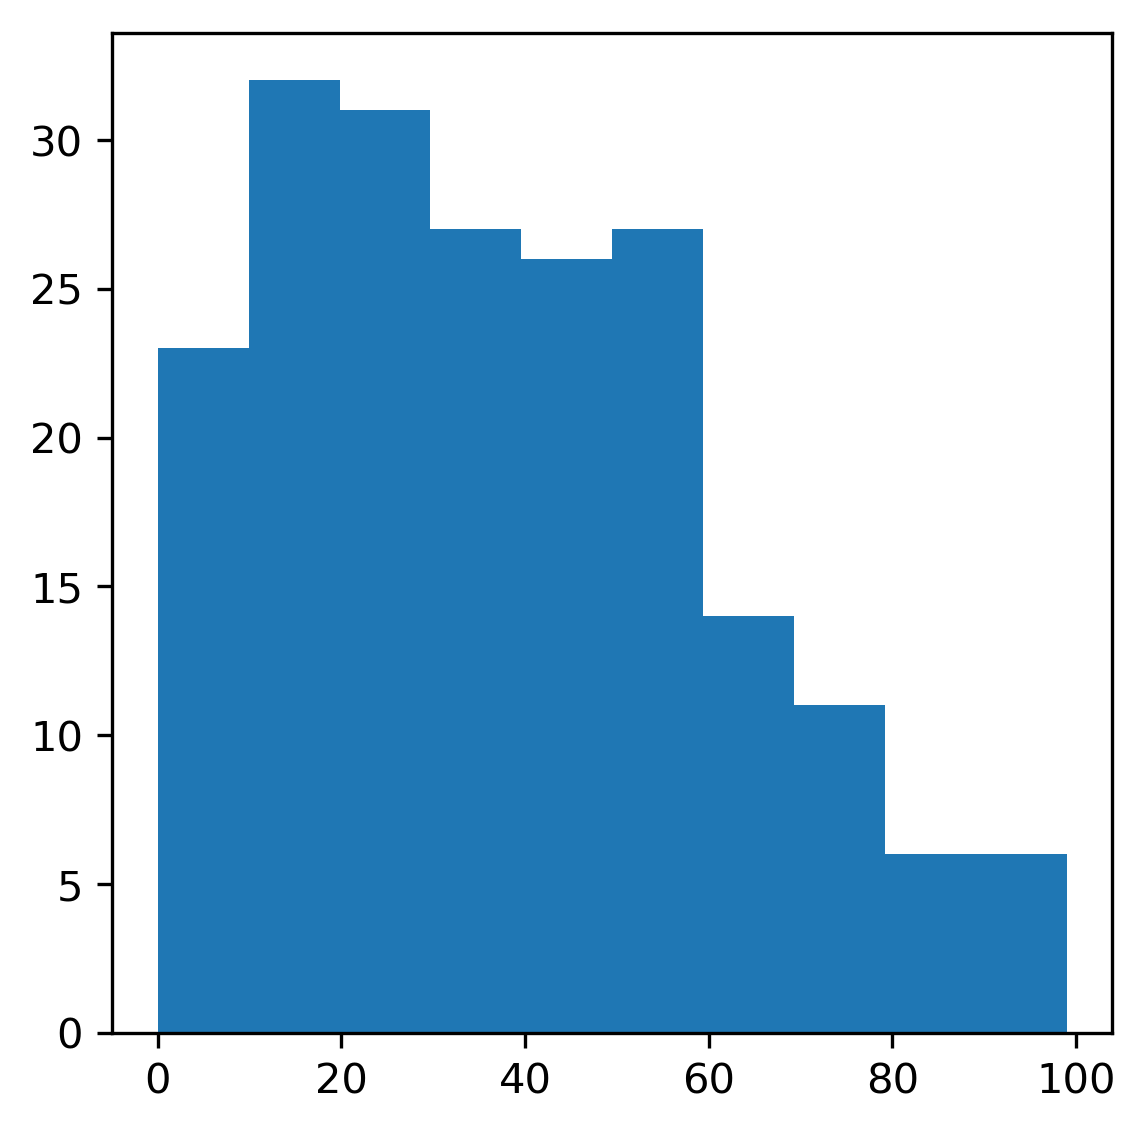

In [29]:
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)   
ax1 = fig.add_axes([ppadh + iph*(pxx/fszh+ppadh2), ppadv + iad*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], label= 'b'+str(n))
                
tmp = MxDf.loc[([pl],[ph],[qd],[ad]),'AvThreshold']   
    
ax1.hist(np.vstack(tmp))

In [12]:
tmp = MxDf.loc[([pl],[ph],[qd],[ad]),'AbsKSthR'].values[ValMask]

In [13]:
np.array(tmp)

array([0.020000000000000018, 0.20999999999999996, 0.010000000000000009,
       0.16000000000000003, 0.1100000000000001, 0.08999999999999997,
       0.16999999999999993, 0.19999999999999996, 0.10999999999999999,
       0.10999999999999999, 0.14, 0.17999999999999994,
       0.010000000000000009, 0.21999999999999997, 0.15000000000000002,
       0.26, 0.0, 0.20999999999999996, 0.07999999999999996, 0.0, 0.0,
       0.26, 0.18999999999999995, 0.07999999999999996, 0.12, 0.0,
       0.22999999999999998, 0.0, 0.0, 0.20999999999999996,
       0.19999999999999996, 0.21999999999999997, 0.040000000000000036,
       0.12, 0.06000000000000005, 0.26, 0.0, 0.19999999999999996,
       0.2799999999999999, 0.07999999999999996, 0.22999999999999998, 0.0,
       0.15000000000000002, 0.20999999999999996, 0.0, 0.15000000000000002,
       0.07999999999999996, 0.30999999999999994, 0.08999999999999997,
       0.050000000000000044, 0.24, 0.30999999999999983,
       0.20999999999999996, 0.12, 0.0, 0.0, 0.1899999999

In [14]:
np.arange(0,1.3,.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2])

In [27]:
np.max(MxDf['AvThreshold'])

99.0